In [1]:
import string
import re
import numpy as np
import pandas as pd
from collections import Counter
import itertools
from time import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import fasttext, FastText
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import get_tmpfile

import tensorflow as tf
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Layer, Input, Embedding, LSTM, Dense, Activation, Bidirectional, Dropout, Conv1D, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, GRU, Attention, Flatten
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import multiply, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

import swifter
import nltk
from nltk.corpus import stopwords
from tensorflow_addons.metrics import HammingLoss

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, accuracy_score

In [124]:
!pip3 freeze > requirements.txt  

In [2]:
tf.test.is_built_with_cuda()

True

# Load Data

In [2]:
# df = pd.read_pickle("alodokter_final_selected_cleaned.pkl")
# df = df.reset_index()
# df = df.iloc[:, 1:]
# df['labelmap'] = df['labelmap'].apply(lambda x: np.array(x))
# df.head()

df = pd.read_pickle("alodokter_final_selected_6.pkl")
df = df.reset_index()
df = df.iloc[:, 1:]
df['labelmap'] = df['labelmap'].apply(lambda x: np.array(x))
df

,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,title_clean_fixtypo,question_clean_fixtypo,text_clean,text_clean_fixtypo
0,Well Chici,Konsumsi zinc pada penderita asam lambung,Dok...saya punya riwayat asam lambung...boleh ...,"Alo Weli, Terimakasih atas pertanyaannya. Zink...",suplemen asam-lambung zinc-sulphate,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,konsumsi zinc derita asam lambung,punya riwayat asam lambung konsumsi zinc,konsumsi zinc derita asam lambung,punya riwayat asam lambung konsumsi zinc,konsumsi zinc derita asam lambung punya riwaya...,konsumsi zinc derita asam lambung punya riwaya...
1,Marusli8765,Tata cara dalam konsumsi Zinc sulphate,"Pagi, Dok...Saya mendapat informasi dari terap...","Alo Marusli, Zinc merupakan salah satu minera...",diare obat zinc-sulphate,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,tata cara konsumsi zinc sulphate,pagi informasi tapis herbal kapsul zinc anak l...,tata cara konsumsi zinc sulphate,pagi informasi tapis herbal kapsul zinc anak l...,tata cara konsumsi zinc sulphate pagi informas...,tata cara konsumsi zinc sulphate pagi informas...
2,Hani Oktaviani,Penggunaan zinc untuk bayi usia 1 bulan,"Mlm dok, sy ingin konsul anak saya usia nya 1 ...","Halo Hani, Zink merupakan mineral yang juga d...",bayi zinc-sulphate,2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,zinc bayi usia bulan,konsul anak usia bulan beberapa hari anak maaf...,zinc bayi usia bulan,konsul anak usia bulan beberapa hari anak maaf...,zinc bayi usia bulan konsul anak usia bulan be...,zinc bayi usia bulan konsul anak usia bulan be...
3,Izha Rin,Dampak jika salah aturan konsumsi minum obat,Selamat malam dok. saya mau tanya. ibu saya tg...,"Selamat malam, terima kasih telah bertanya di ...",obat zat-kimia,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,dampak salah atur konsumsi minum obat,malam tanya periksa kasih obat bilang kalo min...,dampak salah atur konsumsi minum obat,malam tanya periksa kasih obat bilang kalo min...,dampak salah atur konsumsi minum obat malam ta...,dampak salah atur konsumsi minum obat malam ta...
4,Fitriani Widyo Putri,Perhitungan hari pemberian dosis zinc untuk ba...,Bagaimana perhitungan 10 hari dalam mengonsums...,"Alo Fitriani, Zinc dapat membantu dalam penan...",bayi diare zinc-sulphate,3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,hitung hari beri dosis zinc bayi diare,bagaimana hitung hari konsumsi obat diare zinc...,hitung hari beri dosis zinc bayi diare,bagaimana hitung hari konsumsi obat diare zinc...,hitung hari beri dosis zinc bayi diare bagaima...,hitung hari beri dosis zinc bayi diare bagaima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102282,Melani Sagita Anjani,solusi ampuh obat tebaik untuk mengobati penya...,"Malam dok, saya mau nanya? Apa penyakit alergi...","Hi Melani,Alergi merupakan reaksi pertahanan t...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,solusi ampuh obat tebaik obat sakit alergi,malam nanya sakit alergi sembuh obat alergi pa...,solusi ampuh obat tebaik obat sakit alergi,malam nanya sakit alergi sembuh obat alergi pa...,solusi ampuh obat tebaik obat sakit alergi mal...,solusi ampuh obat tebaik obat sakit alergi mal...
102283,Hana Banua Kaltim,apa manfaat injeksi intracutan secara lebih luas?,dok injeksi intra cutan apa hanya untuk menget...,"Hai Hana, Injeksi intrakutan adalah memasukkan...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,manfaat injeksi intracutan cara lebih luas,injeksi intra tahu reaksi alergi,manfaat injeksi intracutan cara lebih luas,injeksi intra tahu reaksi alergi,manfaat injeksi intracutan cara lebih luas inj...,manfaat injeksi intracutan cara lebih luas inj...
102284,Arif Ramn Kimn,Obat untuk alergi makanan,"Hai dok ,, Sy mempunyai keluhan alergi makanan...","Hallo, Penanganan terbaik pada kasus alergi ad...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,obat alergi makan,punya keluh alergi makan telur udang kacang ki...,obat alergi makan,punya keluh alergi makan telur udang kacang ki...,obat alergi makan punya keluh alerg

In [91]:
'''Get max & min length of answers'''
print("MAX length of answer column")
print(df.answer.map(lambda x: len(x)).max())
print("-----")
print("MIN length of answer column")
print(df.answer.map(lambda x: len(x)).min())

MAX length of answer column
16559
-----
MIN length of answer column
50


In [89]:
''' Get the index of the shortest answers '''
lengths = df['answer'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,title_clean_fixtypo,question_clean_fixtypo,text_clean,text_clean_fixtypo
22397,oprani,Apa obat gatal-gatal pada area selangkangan ?,"halo dok, saya mau tanya. selangkangan saya sa...","Halo oprani,Pruritus atau rasa gatal merupakan...",alergi gatal psoriasis kudis eksim infeksi-jam...,7,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,obat gatal gatal area selangkang,tanya selangkang gatal saking gatal sampe garu...,obat gatal gatal area sedangkang,tanya sedangkang gatal saking gatal sampe garu...,obat gatal gatal area selangkang tanya selangk...,obat gatal gatal area sedangkang tanya sedangk...


In [88]:
df.drop([83428, 83436, 84041, 84134, 87080], inplace=True)

In [93]:
df2 = df.reset_index()

In [94]:
df2

,index,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,title_clean_fixtypo,question_clean_fixtypo,text_clean,text_clean_fixtypo
0,0,Well Chici,Konsumsi zinc pada penderita asam lambung,Dok...saya punya riwayat asam lambung...boleh ...,"Alo Weli, Terimakasih atas pertanyaannya. Zink...",suplemen asam-lambung zinc-sulphate,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,konsumsi zinc derita asam lambung,punya riwayat asam lambung konsumsi zinc,konsumsi zinc derita asam lambung,punya riwayat asam lambung konsumsi zinc,konsumsi zinc derita asam lambung punya riwaya...,konsumsi zinc derita asam lambung punya riwaya...
1,1,Marusli8765,Tata cara dalam konsumsi Zinc sulphate,"Pagi, Dok...Saya mendapat informasi dari terap...","Alo Marusli, Zinc merupakan salah satu minera...",diare obat zinc-sulphate,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,tata cara konsumsi zinc sulphate,pagi informasi tapis herbal kapsul zinc anak l...,tata cara konsumsi zinc sulphate,pagi informasi tapis herbal kapsul zinc anak l...,tata cara konsumsi zinc sulphate pagi informas...,tata cara konsumsi zinc sulphate pagi informas...
2,2,Hani Oktaviani,Penggunaan zinc untuk bayi usia 1 bulan,"Mlm dok, sy ingin konsul anak saya usia nya 1 ...","Halo Hani, Zink merupakan mineral yang juga d...",bayi zinc-sulphate,2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,zinc bayi usia bulan,konsul anak usia bulan beberapa hari anak maaf...,zinc bayi usia bulan,konsul anak usia bulan beberapa hari anak maaf...,zinc bayi usia bulan konsul anak usia bulan be...,zinc bayi usia bulan konsul anak usia bulan be...
3,3,Izha Rin,Dampak jika salah aturan konsumsi minum obat,Selamat malam dok. saya mau tanya. ibu saya tg...,"Selamat malam, terima kasih telah bertanya di ...",obat zat-kimia,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,dampak salah atur konsumsi minum obat,malam tanya periksa kasih obat bilang kalo min...,dampak salah atur konsumsi minum obat,malam tanya periksa kasih obat bilang kalo min...,dampak salah atur konsumsi minum obat malam ta...,dampak salah atur konsumsi minum obat malam ta...
4,4,Fitriani Widyo Putri,Perhitungan hari pemberian dosis zinc untuk ba...,Bagaimana perhitungan 10 hari dalam mengonsums...,"Alo Fitriani, Zinc dapat membantu dalam penan...",bayi diare zinc-sulphate,3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,hitung hari beri dosis zinc bayi diare,bagaimana hitung hari konsumsi obat diare zinc...,hitung hari beri dosis zinc bayi diare,bagaimana hitung hari konsumsi obat diare zinc...,hitung hari beri dosis zinc bayi diare bagaima...,hitung hari beri dosis zinc bayi diare bagaima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102203,102282,Melani Sagita Anjani,solusi ampuh obat tebaik untuk mengobati penya...,"Malam dok, saya mau nanya? Apa penyakit alergi...","Hi Melani,Alergi merupakan reaksi pertahanan t...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,solusi ampuh obat tebaik obat sakit alergi,malam nanya sakit alergi sembuh obat alergi pa...,solusi ampuh obat tebaik obat sakit alergi,malam nanya sakit alergi sembuh obat alergi pa...,solusi ampuh obat tebaik obat sakit alergi mal...,solusi ampuh obat tebaik obat sakit alergi mal...
102204,102283,Hana Banua Kaltim,apa manfaat injeksi intracutan secara lebih luas?,dok injeksi intra cutan apa hanya untuk menget...,"Hai Hana, Injeksi intrakutan adalah memasukkan...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,manfaat injeksi intracutan cara lebih luas,injeksi intra tahu reaksi alergi,manfaat injeksi intracutan cara lebih luas,injeksi intra tahu reaksi alergi,manfaat injeksi intracutan cara lebih luas inj...,manfaat injeksi intracutan cara lebih luas inj...
102205,102284,Arif Ramn Kimn,Obat untuk alergi makanan,"Hai dok ,, Sy mempunyai keluhan alergi makanan...","Hallo, Penanganan terbaik pada kasus alergi ad...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,obat alergi makan,punya keluh alergi makan telur udang kacang ki...,obat alergi makan,punya keluh alergi makan telur udang kacang 

In [95]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize


def summarize(text):
    sw = set(stopwords.words("indonesian"))
    words = word_tokenize(text)

    freqTable = dict()
    for word in words:
        word = word.lower()
        if word in sw:
            continue
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1

    # Creatinng a dictianary to keep the score
    sentences = sent_tokenize(text)
    sentenceValue = dict()

    for sentence in sentences:
        for word, freq in freqTable.items():
            if word in sentence.lower():
                if sentence in sentenceValue:
                    sentenceValue[sentence] += freq
                else:
                    sentenceValue[sentence] = freq
    
    sumValues = 0
    for sentence in sentenceValue:
        sumValues += sentenceValue[sentence]

    avg = int(sumValues / len(sentenceValue))
    summary = ''
    for sentence in sentences:
        if (sentence in sentenceValue) and (sentenceValue[sentence] > (avg)):
            summary += " " + sentence

    return summary

In [96]:
'''Get max & min length of answers'''
print("MAX length of answer column")
print(df.answer.map(lambda x: len(x)).max())
print("-----")
print("MIN length of answer column")
print(df.answer.map(lambda x: len(x)).min())

''' Get the index of the shortest answers '''
lengths = df['answer'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df.iloc[argmax]

MAX length of answer column
16559
-----
MIN length of answer column
50


,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,title_clean_fixtypo,question_clean_fixtypo,text_clean,text_clean_fixtypo
22397,oprani,Apa obat gatal-gatal pada area selangkangan ?,"halo dok, saya mau tanya. selangkangan saya sa...","Halo oprani,Pruritus atau rasa gatal merupakan...",alergi gatal psoriasis kudis eksim infeksi-jam...,7,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,obat gatal gatal area selangkang,tanya selangkang gatal saking gatal sampe garu...,obat gatal gatal area sedangkang,tanya sedangkang gatal saking gatal sampe garu...,obat gatal gatal area selangkang tanya selangk...,obat gatal gatal area sedangkang tanya sedangk...


In [97]:
df2['answer_clean'] = df2.answer.swifter.apply(lambda x: summarize(x))
df2

Pandas Apply:   0%|          | 0/102208 [00:00<?, ?it/s]

,index,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,title_clean_fixtypo,question_clean_fixtypo,text_clean,text_clean_fixtypo,answer_clean
0,0,Well Chici,Konsumsi zinc pada penderita asam lambung,Dok...saya punya riwayat asam lambung...boleh ...,"Alo Weli, Terimakasih atas pertanyaannya. Zink...",suplemen asam-lambung zinc-sulphate,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,konsumsi zinc derita asam lambung,punya riwayat asam lambung konsumsi zinc,konsumsi zinc derita asam lambung,punya riwayat asam lambung konsumsi zinc,konsumsi zinc derita asam lambung punya riwaya...,konsumsi zinc derita asam lambung punya riwaya...,Zink (seng) adalah mineral yang dibutuhkan t...
1,1,Marusli8765,Tata cara dalam konsumsi Zinc sulphate,"Pagi, Dok...Saya mendapat informasi dari terap...","Alo Marusli, Zinc merupakan salah satu minera...",diare obat zinc-sulphate,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,tata cara konsumsi zinc sulphate,pagi informasi tapis herbal kapsul zinc anak l...,tata cara konsumsi zinc sulphate,pagi informasi tapis herbal kapsul zinc anak l...,tata cara konsumsi zinc sulphate pagi informas...,tata cara konsumsi zinc sulphate pagi informas...,"Alo Marusli, Zinc merupakan salah satu miner..."
2,2,Hani Oktaviani,Penggunaan zinc untuk bayi usia 1 bulan,"Mlm dok, sy ingin konsul anak saya usia nya 1 ...","Halo Hani, Zink merupakan mineral yang juga d...",bayi zinc-sulphate,2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,zinc bayi usia bulan,konsul anak usia bulan beberapa hari anak maaf...,zinc bayi usia bulan,konsul anak usia bulan beberapa hari anak maaf...,zinc bayi usia bulan konsul anak usia bulan be...,zinc bayi usia bulan konsul anak usia bulan be...,Suplementasi Zink yang diberikan 1 hari sekal...
3,3,Izha Rin,Dampak jika salah aturan konsumsi minum obat,Selamat malam dok. saya mau tanya. ibu saya tg...,"Selamat malam, terima kasih telah bertanya di ...",obat zat-kimia,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,dampak salah atur konsumsi minum obat,malam tanya periksa kasih obat bilang kalo min...,dampak salah atur konsumsi minum obat,malam tanya periksa kasih obat bilang kalo min...,dampak salah atur konsumsi minum obat malam ta...,dampak salah atur konsumsi minum obat malam ta...,"Namun terkait pertanyaan Anda, sebenarnya aka..."
4,4,Fitriani Widyo Putri,Perhitungan hari pemberian dosis zinc untuk ba...,Bagaimana perhitungan 10 hari dalam mengonsums...,"Alo Fitriani, Zinc dapat membantu dalam penan...",bayi diare zinc-sulphate,3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,hitung hari beri dosis zinc bayi diare,bagaimana hitung hari konsumsi obat diare zinc...,hitung hari beri dosis zinc bayi diare,bagaimana hitung hari konsumsi obat diare zinc...,hitung hari beri dosis zinc bayi diare bagaima...,hitung hari beri dosis zinc bayi diare bagaima...,"Alo Fitriani, Zinc dapat membantu dalam pena..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102203,102282,Melani Sagita Anjani,solusi ampuh obat tebaik untuk mengobati penya...,"Malam dok, saya mau nanya? Apa penyakit alergi...","Hi Melani,Alergi merupakan reaksi pertahanan t...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,solusi ampuh obat tebaik obat sakit alergi,malam nanya sakit alergi sembuh obat alergi pa...,solusi ampuh obat tebaik obat sakit alergi,malam nanya sakit alergi sembuh obat alergi pa...,solusi ampuh obat tebaik obat sakit alergi mal...,solusi ampuh obat tebaik obat sakit alergi mal...,"Hi Melani,Alergi merupakan reaksi pertahanan ..."
102204,102283,Hana Banua Kaltim,apa manfaat injeksi intracutan secara lebih luas?,dok injeksi intra cutan apa hanya untuk menget...,"Hai Hana, Injeksi intrakutan adalah memasukkan...",alergi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,manfaat injeksi intracutan cara lebih luas,injeksi intra tahu reaksi alergi,manfaat injeksi intracutan cara lebih luas,injeksi intra tahu reaksi alergi,manfaat injeksi intracutan cara lebih luas inj...,manfaat injeksi intracutan cara lebih luas inj...,"Hai Hana, Injeks

In [98]:
df2['labelmap'] = df2['labelmap'].map(list)
df2.to_csv('alodokter_final_selected_7.csv', encoding='utf8',index=False)
df2.to_pickle('alodokter_final_selected_7.pkl')

In [48]:
df_labels = pd.read_csv("labels.csv")
df_labels

,index,label
0,0,menstruasi
1,1,kehamilan
2,2,obat
3,3,asam-lambung
4,4,bayi
5,5,sakit-kepala
6,6,benjolan
7,7,kulit
8,8,alergi
9,9,kontrasepsi


In [49]:
labels = df_labels['label'].values
labels

array(['menstruasi', 'kehamilan', 'obat', 'asam-lambung', 'bayi',
       'sakit-kepala', 'benjolan', 'kulit', 'alergi', 'kontrasepsi'],
      dtype=object)

In [8]:
one_hot_labels = pd.DataFrame(df.labelmap.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
one_hot_labels

,menstruasi,kehamilan,obat,asam-lambung,bayi,sakit-kepala,benjolan,kulit,alergi,kontrasepsi
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
102282,0,0,1,0,0,0,0,0,0,0
102283,0,0,1,0,0,0,0,0,0,0
102284,0,0,1,0,0,0,0,0,0,0
102285,0,0,1,0,0,0,0,0,0,0


# Data splitting: Cleaned Question

In [9]:
# Store 'title, 'question' and 'labelmap' in array 'formatted_data' (for model training & exporting result in CSV later)
formatted_data = pd.concat([df, one_hot_labels], axis=1)
formatted_data

,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,...,menstruasi,kehamilan,obat,asam-lambung,bayi,sakit-kepala,benjolan,kulit,alergi,kontrasepsi
0,subertty,"Cara mengatasi gatal, bintik bernanah warna pu...","Dok, saya mengalami penyakit kulit di wajah aw...","Alo, terimakasih sudah bertanya di alodokter.c...",kulit gatal wajah,3,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,cara atas gatal bintik nanah warna putih rasa ...,alam sakit kulit wajah awalny gatal gatal trus...,...,0,0,0,0,0,0,0,1,0,0
1,Mflkh,Obat untuk Bekas Jerawat membuat Kulit Mengeri...,Saya seorang mahasiswi yg belum mengikuti kuli...,Halo Mflkh. Terimakasih atas pertanyaannya. Ob...,kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,obat bekas jerawat buat kulit kering perih,orang mahasiswi ikut kuliah sama sekali sering...,...,0,0,0,0,0,0,0,1,0,0
2,Andreanputraalvaro,Benjolan daging di dalam kulit pipi,"Hallo dok, Saya mempunyai masalah masalah pada...",Halo Andreanputraalvaro....... Terimakasih ata...,benjolan wajah,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,benjol daging kulit pipi,punya masalah masalah kulit pipi macam benjol ...,...,0,0,0,0,0,0,1,0,0,0
3,Indah Ayu,Penanganan untuk kulit wajah kering,"Assalamualaikum, dok beberapa hari ini kulit m...","Halo Indah, Saya memahami kekhawatiran Anda. ...",kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,tangan kulit wajah kering,beberapa hari kulit muka kering daerah pipi da...,...,0,0,0,0,0,0,0,1,0,0
4,Risna Nurwinda,Solusi pengobatan luka di wajah akibat krim pe...,"assalamualaikum dok, saya risna umur saya 19 t...",Halo Risna....... Terimakasih atas pertanyaan ...,alergi wajah,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,solusi obat luka wajah akibat krim putih wajah,risna umur tanya gimana cara ngobatin luka waj...,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102282,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,Alo Marini ! Terima kasih atas pertanyaannya d...,obat acetylcysteine,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,mekanisme kerja obat acetylcysisteine,tanya bagaimana mekanisme kerja obat acetylsis...,...,0,0,1,0,0,0,0,0,0,0
102283,Aeniie Jr.,Efek samping obat pada pasien sakit paru-paru,"Selamat malam dok, saya mau bertanya..Bapak sa...","Selamat siang, terimakasih atas pertanyaannya ...",obat abses-paru,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,efek samping obat pasien sakit paru paru,malam tanya bapak hbis masuk rumah sakit fonis...,...,0,0,1,0,0,0,0,0,0,0
102284,Suna,"Pemberian obat untuk anak yang sakit gigi, gus...",Dok saya mau tanya anak saya sakit gigi gusi b...,"Alo, terimakasih atas pertanyaannya. Abses gig...",sakit-gigi obat abses-gigi,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,beri obat anak sakit gigi gusi bengkak abses gigi,tanya anak sakit gigi gusi bengkak abses parah...,...,0,0,1,0,0,0,0,0,0,0
102285,Sienna,Obat yang dapat digunakan untuk mengatasi abse...,"Dok, sblumnya gigi depan saya ngilu dan bengka...","Alo, Obat yang Anda sebutkan mengandung kaliu...",obat abses-gigi,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,obat atas abses gigi pecah keluar nanah,sblumnya gigi depan ngilu bengkak gitu anjur k...,...,0,0,1,0,0,0,0,0,0,0


In [7]:
formatted_data['text_clean'].values[0]

'konsumsi zinc derita asam lambung punya riwayat asam lambung konsumsi zinc'

## FastText Word Embedding

Gensim migrate from 3.x to 4.x https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [13]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz

In [14]:
# !gunzip -k "cc.id.300.bin.gz"

In [29]:
!pip install --upgrade gensim --user

In [4]:
embedding_path = "cc.id.300.bin/cc.id.300.bin"
ft = fasttext.load_facebook_model(embedding_path)
# ft.wv.save('fasttext_gensim.model')

In [11]:
# fname = get_tmpfile("C:\\Users/Tugas Akhir/Documents/ROSA/fasttext_gensim.model")
# ft = fasttext.load_model(fname)

In [12]:
ft.vector_size

300

In [8]:
vocab = ft.wv
len(vocab)

2000000

## Word2Vec Word Embedding

In [ ]:
path = 'idwiki/idwiki_word2vec_300.model'
w2v_model = Word2Vec.load(path)

In [5]:
# word_vectors = w2v_model.wv
# word_vectors.save("id-word2vec")

# Load back with memory-mapping = read-only, shared across processes.
id_w2v = KeyedVectors.load("id-word2vec", mmap='r')
len(id_w2v)

331792

In [26]:
id_w2v["komputer"]

memmap([ 1.8987454e+00,  6.3871616e-01,  6.2249232e-02, -9.8417026e-01,
         1.9442661e+00,  6.6903222e-01,  4.2731267e-01,  2.0785322e+00,
        -1.1744146e+00, -7.9381809e-02,  2.7540359e+00,  1.5211607e+00,
        -1.0047150e+00, -2.9493436e-01, -2.3271897e+00,  1.4287660e+00,
         2.1902096e-01,  6.8374705e-01, -3.9510259e-01,  4.6455598e-01,
         6.6141516e-01, -7.9703677e-01,  3.5268018e-01,  2.0759397e+00,
         9.5513713e-01,  1.8345157e+00, -2.6075218e+00,  9.1378939e-01,
        -6.4605705e-02, -1.4265233e+00,  3.7242168e-01, -4.3149695e-02,
         9.4253010e-01, -8.8542473e-01,  4.2161080e-01,  2.6199522e+00,
        -1.1772690e+00,  4.3350425e-01,  1.8209504e+00,  8.2113552e-01,
         1.1391125e+00, -1.1978949e+00, -1.2656624e+00, -1.1175097e+00,
         1.8944209e+00, -1.2154016e+00, -1.7810198e+00,  1.1399087e+00,
        -7.7121860e-01, -7.9109150e-01,  2.3734912e-01,  2.7953010e+00,
         1.1560320e+00,  2.3024731e+00,  6.6927043e-03,  1.48492

## Fix typos (gausah di-run, udah di Data Selection)

In [6]:
words = list(id_w2v.key_to_index)

w_rank = {}
for i, word in enumerate(words):
    w_rank[word] = i

# Save word rank
WORDS = w_rank

In [17]:
dict(itertools.islice(WORDS.items(), 10))

{',': 0,
 '.': 1,
 '</s>': 2,
 'yang': 3,
 'dan': 4,
 '"': 5,
 'di': 6,
 ')': 7,
 '(': 8,
 'dengan': 9}

In [39]:
def P(word):
    # Probability of `word`
    return - WORDS.get(word, 0)

def correction(word):
    # Most probable spelling correction for word
    return max(candidates(word), key=P)

def candidates(word):
    # Generate possible spelling corrections for word
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])
    
def known(words):
    # Subset of `words` that appear in WORDS
    return set(w for w in words if w in WORDS)

def edits1(word):
    # Words that are 1 edit away from `word`
    letters = 'abcdefghjklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    # All edits that are 2 edits away from `word`
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [19]:
def fix_typos(text):
    text = text.split(" ")
    words = [correction(word) for word in text]
    result = " ".join(words).strip()
    return result

In [20]:
sample = formatted_data.iloc[:1]
sample['text_clean_fixtypo'] = sample.text_clean.swifter.apply(lambda x: fix_typos(x))
sample

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_21296\715057783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['text_clean_fixtypo'] = sample.text_clean.swifter.apply(lambda x: fix_typos(x))


,title,title_clean,question,question_clean,labelmap,text_clean,menstruasi,kehamilan,obat,asam-lambung,bayi,sakit-kepala,benjolan,kulit,alergi,kontrasepsi,text_clean_fixtypo
0,Penggunaan zinc untuk bayi usia 1 bulan,zinc bayi usia bulan,"Mlm dok, sy ingin konsul anak saya usia nya 1 ...",konsul anak usia bulan beberapa hari anak maaf...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",zinc bayi usia bulan konsul anak usia bulan be...,0,0,0,1,0,0,0,0,0,0,zinc bayi usia bulan konsul anak usia bulan be...


## Tokenizing + Splitting Cleaned Question

In [21]:
tfidf_vect = TfidfVectorizer(max_features=10000)
tfidf_vect.fit(formatted_data['text_clean'])

# print(tfidf_vect.vocabulary_)

TfidfVectorizer(max_features=10000)

## If tokenizer not yet created

In [12]:
# Tokenize 'text_clean_fixtypo' column
tokenizer_text_fixtypo = Tokenizer()
tokenizer_text_fixtypo.fit_on_texts(formatted_data['text_clean_fixtypo'])
with open('tokenizer_text_fixtypo.pickle', 'wb') as handle:
    pickle.dump(tokenizer_text_fixtypo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Tokenize 'title_clean_fixtypo' column
tokenizer_title_fixtypo = Tokenizer()
tokenizer_title_fixtypo.fit_on_texts(formatted_data['title_clean_fixtypo'])
with open('tokenizer_title_fixtypo.pickle', 'wb') as handle:
    pickle.dump(tokenizer_title_fixtypo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Tokenize 'question_clean_fixtypo' column
tokenizer_question_fixtypo = Tokenizer()
tokenizer_question_fixtypo.fit_on_texts(formatted_data['question_clean_fixtypo'])
with open('tokenizer_question_fixtypo.pickle', 'wb') as handle:
    pickle.dump(tokenizer_question_fixtypo, handle, protocol=pickle.HIGHEST_PROTOCOL)

## If tokenizer created

In [13]:
with open('tokenizer_text_fixtypo.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

max_length = 300

Found 41091 unique tokens.


### Train Test sudah di-split

In [14]:
stop_factory = StopWordRemoverFactory()
more_stopwords = ['terimakasih', 'dong', ]
data_stopwords = stop_factory.get_stop_words() + more_stopwords

NameError: name 'StopWordRemoverFactory' is not defined

In [18]:
train_df = pd.read_pickle("alodokter_train_text.pkl")
train_df = train_df.reset_index()
train_df = train_df.iloc[:, 1:]
train_df['label'] = train_df['label'].apply(lambda x: np.array(x))

test_df = pd.read_pickle("alodokter_test_text.pkl")
test_df = test_df.reset_index()
test_df = test_df.iloc[:, 1:]
test_df['label'] = test_df['label'].apply(lambda x: np.array(x))

In [19]:
train_df['text_clean'] = train_df['text_clean'].apply(lambda xs: ''.join(str(x) for x in xs))
test_df['text_clean'] = test_df['text_clean'].apply(lambda xs: ''.join(str(x) for x in xs))

In [20]:
train_one_hot = pd.DataFrame(train_df.label.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
test_one_hot = pd.DataFrame(test_df.label.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])

In [21]:
train_df = pd.concat([train_df, train_one_hot], axis=1)
test_df = pd.concat([test_df, test_one_hot], axis=1)

In [22]:
X_train = train_df[['text_clean']].values
X_test = test_df[['text_clean']].values

y_train = train_df[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values
y_test = test_df[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values

### Train Test belum di-split

#### Use skmultilearn for iterative splitting

In [29]:
# Split X and y
from skmultilearn.model_selection import iterative_train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(formatted_data[['title_clean_fixtypo']].values, formatted_data[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values, test_size=0.3)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(formatted_data[['question_clean_fixtypo']].values, formatted_data[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values, test_size=0.3)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(formatted_data[['text_clean_fixtypo']].values, formatted_data[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values, test_size=0.3)

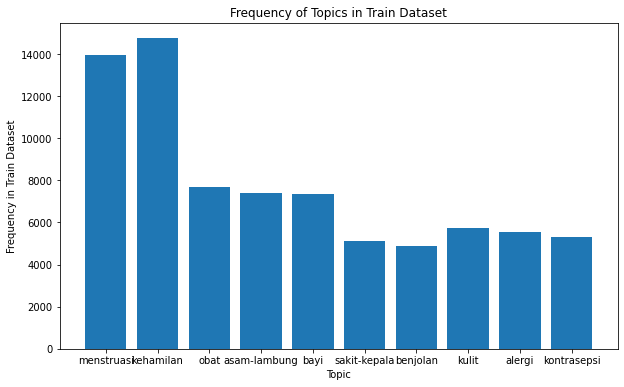

In [30]:
# Check distribution of classes
vis_selected = pd.DataFrame(y_train_3, columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
vis_selected = vis_selected.astype(int)

counts = vis_selected.sum()

plt.figure(figsize=(10,6))
plt.bar(np.array(vis_selected.columns), counts)
plt.xlabel('Topic')
plt.ylabel('Frequency in Train Dataset')
plt.title('Frequency of Topics in Train Dataset')
plt.show()

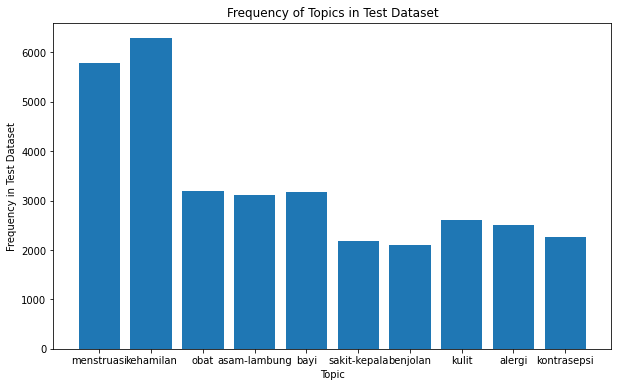

In [32]:
# Check distribution of classes
vis_selected = pd.DataFrame(y_test_3, columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
vis_selected = vis_selected.astype(int)

counts = vis_selected.sum()

plt.figure(figsize=(10,6))
plt.bar(np.array(vis_selected.columns), counts)
plt.xlabel('Topic')
plt.ylabel('Frequency in Test Dataset')
plt.title('Frequency of Topics in Test Dataset')
plt.show()

#### Export train_df and test_df

In [51]:
train_df_1 = pd.DataFrame()
test_df_1 = pd.DataFrame()

In [52]:
y_train_list = list(y_train_1)

train_df_1['title_clean'] = list(X_train_1)
train_df_1['label'] = pd.Series(y_train_list)

y_test_list = list(y_test_1)

test_df_1['title_clean'] = list(X_test_1)
test_df_1['label'] = pd.Series(y_test_list)

In [54]:
train_df_2 = pd.DataFrame()
test_df_2 = pd.DataFrame()

y_train_list = list(y_train_2)

train_df_2['question_clean'] = list(X_train_2)
train_df_2['label'] = pd.Series(y_train_list)

y_test_list = list(y_test_2)

test_df_2['question_clean'] = list(X_test_2)
test_df_2['label'] = pd.Series(y_test_list)

In [55]:
train_df_3 = pd.DataFrame()
test_df_3 = pd.DataFrame()

y_train_list = list(y_train_3)

train_df_3['text_clean'] = list(X_train_3)
train_df_3['label'] = pd.Series(y_train_list)

y_test_list = list(y_test_3)

test_df_3['text_clean'] = list(X_test_3)
test_df_3['label'] = pd.Series(y_test_list)

In [56]:
train_df_1.to_pickle('alodokter_train_title.pkl')
train_df_2.to_pickle('alodokter_train_question.pkl')
train_df_3.to_pickle('alodokter_train_text.pkl')

test_df_1.to_pickle('alodokter_test_title.pkl')
test_df_2.to_pickle('alodokter_test_question.pkl')
test_df_3.to_pickle('alodokter_test_text.pkl')

### Vectorizing Text

In [23]:
# Vectorize text
train_sequences = tokenizer.texts_to_sequences(np.concatenate(X_train))
test_sequences = tokenizer.texts_to_sequences(np.concatenate(X_test))

# Create padded sequences for vectorized text
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [24]:
X_train = train_padded_sequences
X_test = test_padded_sequences

### ⚠ RUN ONLY IF y NOT YET SPLIT

In [16]:
# Create one hot labels for y

# If y is not yet split before
train_one_hot_labels = pd.DataFrame(train_df.labelmap.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
test_one_hot_labels = pd.DataFrame(test_df.labelmap.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
y_train = train_one_hot_labels
y_test = test_one_hot_labels

# If y is already split, no need

NameError: name 'train_df' is not defined

### Construct embedding matrix

In [37]:
id_w2v["apkah"]

KeyError: "Key 'apkah' not present"

In [25]:
embedding_matrix = np.zeros((len(word_index) + 1, ft.vector_size))
oov = 0
oov_list = []

'''
For Word2Vec
'''
# for word, i in word_index.items():
#     try:
#         embedding_matrix[i] = id_w2v[woidrd]
#     except KeyError:
#         oov += 1
#         oov_list.append(word)
#         continue

'''
For FastText
'''
for word, i in word_index.items():
    if ft.wv[word] is not None:
        embedding_matrix[i] = ft.wv[word]
    else:
        oov += 1

print("Out of vocab: ")
print(oov)

Out of vocab: 
0


In [26]:
w2v_weights = ft.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))
print("Word Index: {}".format(len(word_index)))

Vocabulary Size: 2000000 - Embedding Dim: 300
Word Index: 41091


# 🌐 Universal Parameters

In [27]:
epochs1 = 10
epochs2 = 50

val_split1 = 0.1
val_split2 = 0.33

batch_size1 = 32
batch_size2 = 64

In [28]:
input_dim = len(word_index) + 1
output_dim = ft.vector_size
input_dim

41092

In [105]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [21]:
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [24]:
STEPS_PER_EPOCH = len(X_train)//batch_size2
STEPS_PER_EPOCH

1034

In [25]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [148]:
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    
    return np.mean(acc_list)

# BiLSTM

## (👑 Current Best) Original (single, units=32)

### Build Model

In [29]:
BiLSTM_model = Sequential([
    Embedding(input_dim, output_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(units=32, return_sequences=True)),
    Dropout(0.2),
    GlobalMaxPool1D(),
    Dense(10, activation='sigmoid')
])

BiLSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          12327600  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          85248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 12,413,498
Trainable params: 85,898
Non-tr

In [33]:

mc = ModelCheckpoint('BestModels/bilstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [34]:
BiLSTM_model_fit = BiLSTM_model.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
BiLSTM_model.save('BiLSTM')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.6359
Epoch 1: val_accuracy improved from -inf to 0.60967, saving model to BestModels\bilstm.h5
931/931 [==============================] - 475s 509ms/step - loss: 0.2180 - accuracy: 0.6359 - val_loss: 0.2094 - val_accuracy: 0.6097
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.7769
Epoch 2: val_accuracy improved from 0.60967 to 0.69154, saving model to BestModels\bilstm.h5
931/931 [==============================] - 399s 429ms/step - loss: 0.1222 - accuracy: 0.7769 - val_loss: 0.1622 - val_accuracy: 0.6915
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.7877
Epoch 3: val_accuracy improved from 0.69154 to 0.74471, saving model to BestModels\bilstm.h5
931/931 [==============================] - 381s 409ms/step - loss: 0.1059 - accuracy: 0.7877 - val_loss: 0.1441 - val_accuracy: 0.7447
Epoch 4/50
931/931 [===========

INFO:tensorflow:Assets written to: BiLSTM\assets


INFO:tensorflow:Assets written to: BiLSTM\assets


### Evaluate Model

In [35]:
BiLSTM_best = load_model("BestModels/bilstm.h5")
BiLSTM_train_score = BiLSTM_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTM_train_score[0])
print('Train Accuracy:', BiLSTM_train_score[1])

BiLSTM_test_score = BiLSTM_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTM_test_score[0])
print('Test Accuracy:', BiLSTM_test_score[1])

1035/1035 [==============================] - 248s 239ms/step - loss: 0.0649 - accuracy: 0.8539
Train Loss: 0.06490775942802429
Train Accuracy: 0.8539444804191589
444/444 [==============================] - 108s 244ms/step - loss: 0.0856 - accuracy: 0.8175
Test Loss: 0.08561484515666962
Test Accuracy: 0.8174963593482971


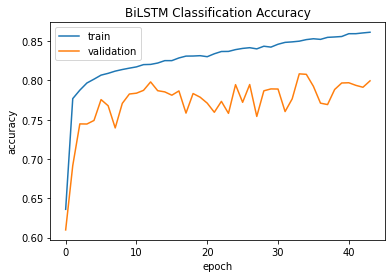

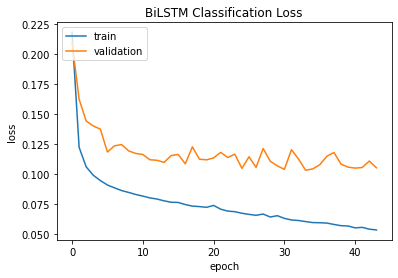

In [36]:
history_dict = BiLSTM_model_fit.history
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])

plt.title('BiLSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])

plt.title('BiLSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [37]:
BiLSTM_pred = BiLSTM_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiLSTM_predictions = (BiLSTM_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTM_predictions))

444/444 [==============================] - 264s 593ms/step
0.7533030335059718


In [39]:
report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTM_predictions, target_names=labels, output_dict=True)
).transpose()

report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.896126,0.888595,0.892345,4165.0
kehamilan,0.858222,0.840637,0.849339,3514.0
obat,0.827061,0.779537,0.802596,3411.0
asam-lambung,0.913805,0.819436,0.864051,3118.0
bayi,0.940651,0.957765,0.949131,3078.0
sakit-kepala,0.906755,0.943253,0.924644,3031.0
benjolan,0.938959,0.932737,0.935838,3018.0
kulit,0.719081,0.782752,0.749567,3038.0
alergi,0.763989,0.660197,0.708311,3040.0
kontrasepsi,0.928677,0.825558,0.874087,3044.0


In [40]:
cf_matrix = multilabel_confusion_matrix(y_test, BiLSTM_predictions)
# TN  FP
# FN  TP
cf_matrix

array([[[23789,   429],
        [  464,  3701]],

       [[24381,   488],
        [  560,  2954]],

       [[24416,   556],
        [  752,  2659]],

       [[25024,   241],
        [  563,  2555]],

       [[25119,   186],
        [  130,  2948]],

       [[25058,   294],
        [  172,  2859]],

       [[25182,   183],
        [  203,  2815]],

       [[24416,   929],
        [  660,  2378]],

       [[24723,   620],
        [ 1033,  2007]],

       [[25146,   193],
        [  531,  2513]]], dtype=int64)

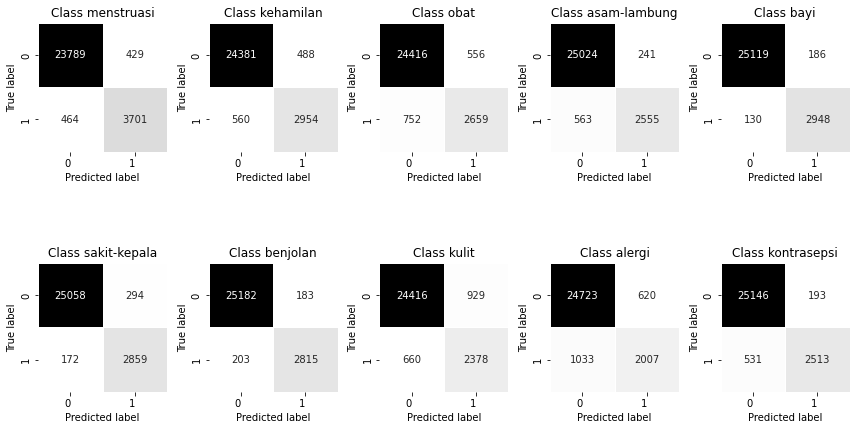

<Figure size 432x288 with 0 Axes>

In [41]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTM.png', bbox_inches="tight")

## Modification #1

In [67]:
BiLSTM_model = Sequential([
    Embedding(input_dim, output_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(units=32, return_sequences=True)),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='sigmoid')
])

BiLSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          10939500  
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 64)          85248     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 300, 64)           0         
                                                                 
 flatten_1 (Flatten)         (None, 19200)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               4915456   
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                      

In [68]:
mc = ModelCheckpoint('BestModels/bilstm_modif1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTM_model_fit = BiLSTM_model.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
BiLSTM_model.save('BiLSTM_modif1')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.7412
Epoch 1: val_accuracy improved from -inf to 0.75937, saving model to BestModels\bilstm_modif1.h5
931/931 [==============================] - 485s 517ms/step - loss: 0.1320 - accuracy: 0.7412 - val_loss: 0.1307 - val_accuracy: 0.7594
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.8006
Epoch 2: val_accuracy did not improve from 0.75937
931/931 [==============================] - 492s 529ms/step - loss: 0.0944 - accuracy: 0.8006 - val_loss: 0.1181 - val_accuracy: 0.7548
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.8114
Epoch 3: val_accuracy improved from 0.75937 to 0.79607, saving model to BestModels\bilstm_modif1.h5
931/931 [==============================] - 581s 624ms/step - loss: 0.0854 - accuracy: 0.8114 - val_loss: 0.1065 - val_accuracy: 0.7961
Epoch 4/50
931/931 [==============================] - ETA: 

INFO:tensorflow:Assets written to: BiLSTM_modif1\assets


INFO:tensorflow:Assets written to: BiLSTM_modif1\assets


In [70]:
BiLSTM_m1_best = load_model("BestModels/bilstm_modif1.h5")
BiLSTM_train_score = BiLSTM_m1_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTM_train_score[0])
print('Train Accuracy:', BiLSTM_train_score[1])

BiLSTM_test_score = BiLSTM_m1_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTM_test_score[0])
print('Test Accuracy:', BiLSTM_test_score[1])

1035/1035 [==============================] - 422s 407ms/step - loss: 0.0407 - accuracy: 0.8721
Train Loss: 0.04065731167793274
Train Accuracy: 0.8720861673355103
444/444 [==============================] - 180s 406ms/step - loss: 0.0961 - accuracy: 0.8027
Test Loss: 0.09606834501028061
Test Accuracy: 0.8027057647705078


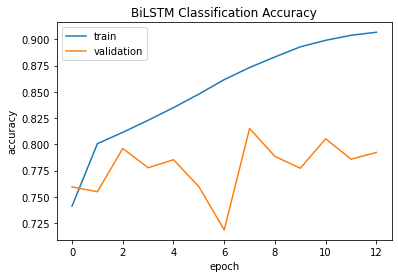

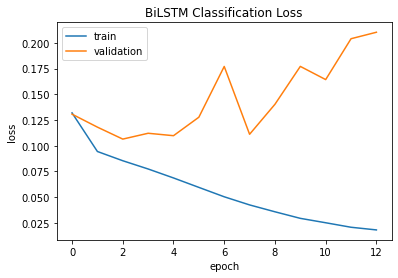

In [71]:
history_dict = BiLSTM_model_fit.history
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])

plt.title('BiLSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])

plt.title('BiLSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [72]:
BiLSTM_pred = BiLSTM_m1_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiLSTM_predictions = (BiLSTM_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTM_predictions))

444/444 [==============================] - 179s 402ms/step
0.7713500563697858


In [73]:
report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTM_predictions, target_names=labels, output_dict=True)
).transpose()

report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.928764,0.826411,0.874603,4165.0
kehamilan,0.867677,0.847183,0.857307,3514.0
obat,0.828162,0.829376,0.828768,3411.0
asam-lambung,0.874724,0.889031,0.881820,3118.0
bayi,0.964420,0.915854,0.939510,3078.0
sakit-kepala,0.915260,0.965688,0.939798,3031.0
benjolan,0.941099,0.947647,0.944362,3018.0
kulit,0.727526,0.772548,0.749361,3038.0
alergi,0.775612,0.615132,0.686113,3040.0
kontrasepsi,0.876539,0.888633,0.882545,3044.0


In [74]:
cf_matrix = multilabel_confusion_matrix(y_test, BiLSTM_predictions)
# TN  FP
# FN  TP
cf_matrix

array([[[23955,   264],
        [  723,  3442]],

       [[24416,   454],
        [  537,  2977]],

       [[24386,   587],
        [  582,  2829]],

       [[24869,   397],
        [  346,  2772]],

       [[25202,   104],
        [  259,  2819]],

       [[25082,   271],
        [  104,  2927]],

       [[25187,   179],
        [  158,  2860]],

       [[24467,   879],
        [  691,  2347]],

       [[24803,   541],
        [ 1170,  1870]],

       [[24959,   381],
        [  339,  2705]]], dtype=int64)

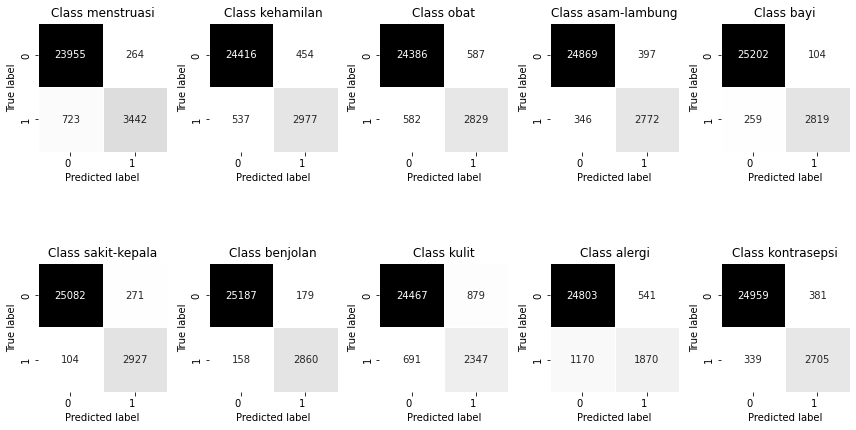

<Figure size 432x288 with 0 Axes>

In [75]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTM-m1.png', bbox_inches="tight")

## 👉 Adjustment to BiLSTM Original

In [106]:
BiLSTM_model = Sequential([
    Embedding(input_dim, output_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(units=32, return_sequences=True)),
    Dropout(0.2),
    GlobalMaxPool1D(),
    Dense(10, activation='sigmoid')
])

BiLSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          12327600  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          85248     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 300, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 12,413,498
Trainable params: 85,898
Non-tr

In [107]:
mc = ModelCheckpoint('BestModels/bilstm_fixtypo2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTM_model_fit = BiLSTM_model.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
BiLSTM_model.save('BiLSTM_fixtypo2')

Epoch 1/50
1007/1007 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.6513
Epoch 1: val_accuracy improved from -inf to 0.80670, saving model to BestModels\bilstm_fixtypo2.h5
1007/1007 [==============================] - 825s 818ms/step - loss: 0.2021 - accuracy: 0.6513 - val_loss: 0.1300 - val_accuracy: 0.8067
Epoch 2/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.8189
Epoch 2: val_accuracy improved from 0.80670 to 0.83170, saving model to BestModels\bilstm_fixtypo2.h5
1007/1007 [==============================] - 771s 765ms/step - loss: 0.1067 - accuracy: 0.8189 - val_loss: 0.1067 - val_accuracy: 0.8317
Epoch 3/50
1007/1007 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.8318
Epoch 3: val_accuracy improved from 0.83170 to 0.84302, saving model to BestModels\bilstm_fixtypo2.h5
1007/1007 [==============================] - 802s 796ms/step - loss: 0.0930 - accuracy: 0.8318 - val_loss: 0.0943 - val_accuracy:

INFO:tensorflow:Assets written to: BiLSTM_fixtypo2\assets


INFO:tensorflow:Assets written to: BiLSTM_fixtypo2\assets


### Evaluate

In [108]:
BiLSTM_best = load_model("BestModels/bilstm_fixtypo2.h5")
BiLSTM_train_score = BiLSTM_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTM_train_score[0])
print('Train Accuracy:', BiLSTM_train_score[1])

BiLSTM_test_score = BiLSTM_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTM_test_score[0])
print('Test Accuracy:', BiLSTM_test_score[1])

1119/1119 [==============================] - 329s 294ms/step - loss: 0.0702 - accuracy: 0.8713
Train Loss: 0.07015479356050491
Train Accuracy: 0.8712849020957947
480/480 [==============================] - 141s 293ms/step - loss: 0.0804 - accuracy: 0.8487
Test Loss: 0.08042658865451813
Test Accuracy: 0.8486655354499817


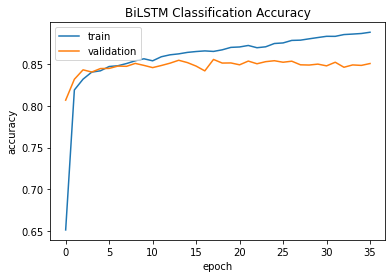

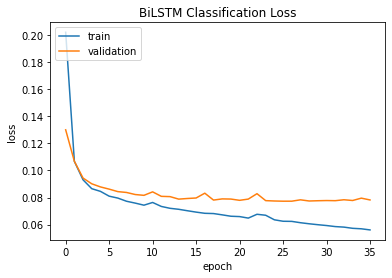

In [109]:
history_dict = BiLSTM_model_fit.history
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])

plt.title('BiLSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])

plt.title('BiLSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [110]:
BiLSTM_pred = BiLSTM_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiLSTM_predictions = (BiLSTM_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTM_predictions))

480/480 [==============================] - 98s 202ms/step
0.7770717241828787


In [111]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), BiLSTM_predictions)
hamming_loss.result().numpy()

0.030048542

In [112]:
report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTM_predictions, target_names=labels, output_dict=True)
).transpose()

report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.892205,0.918378,0.905102,5795.0
kehamilan,0.899440,0.893147,0.896282,6289.0
obat,0.810526,0.797302,0.803860,3187.0
asam-lambung,0.919073,0.880064,0.899146,3110.0
bayi,0.939650,0.949147,0.944375,3166.0
sakit-kepala,0.930836,0.887769,0.908792,2183.0
benjolan,0.918789,0.913085,0.915928,2094.0
kulit,0.701715,0.724403,0.712879,2598.0
alergi,0.693755,0.692923,0.693339,2501.0
kontrasepsi,0.869853,0.756076,0.808983,2263.0


In [79]:
cf_matrix = multilabel_confusion_matrix(y_test, BiLSTM_predictions)
# TN  FP
# FN  TP
cf_matrix

array([[[24199,   693],
        [  401,  5394]],

       [[23844,   554],
        [  715,  5574]],

       [[27038,   462],
        [  763,  2424]],

       [[27289,   288],
        [  344,  2766]],

       [[27323,   198],
        [  152,  3014]],

       [[28336,   168],
        [  204,  1979]],

       [[28449,   144],
        [  201,  1893]],

       [[27425,   664],
        [  792,  1806]],

       [[27476,   710],
        [  823,  1678]],

       [[28244,   180],
        [  660,  1603]]], dtype=int64)

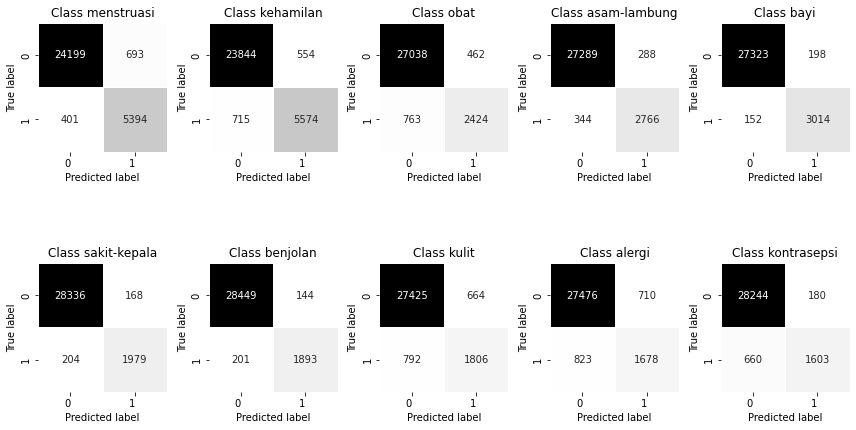

<Figure size 432x288 with 0 Axes>

In [80]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTM_fixtypo.png', bbox_inches="tight")

## (🚩) Improvement 1 (single, units=32, use sequential, use regularizer)

### Build Model

In [50]:
tf.keras.backend.clear_session()

BiLSTM_2 = Sequential()
BiLSTM_2.add(Input(shape=(max_length,)))
BiLSTM_2.add(Embedding(input_dim, output_dim, weights=[embedding_matrix], trainable=False))
BiLSTM_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01))))
BiLSTM_2.add(Dropout(0.2))
BiLSTM_2.add(GlobalMaxPool1D())
BiLSTM_2.add(Dense(10, activation='sigmoid'))

BiLSTM_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTM_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          10939500  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          85248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 11,025,398
Trainable params: 85,898
Non-tr

In [51]:
mc = ModelCheckpoint('BestModels/bilstm_2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTM_2_fit = BiLSTM_2.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es,mc])
BiLSTM_2.save('BiLSTM_2')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.2190
Epoch 1: val_accuracy improved from -inf to 0.00604, saving model to BestModels\bilstm_2.h5
931/931 [==============================] - 808s 866ms/step - loss: 0.4803 - accuracy: 0.2190 - val_loss: 0.3761 - val_accuracy: 0.0060
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.3731
Epoch 2: val_accuracy improved from 0.00604 to 0.04033, saving model to BestModels\bilstm_2.h5
931/931 [==============================] - 741s 796ms/step - loss: 0.2839 - accuracy: 0.3731 - val_loss: 0.3367 - val_accuracy: 0.0403
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.3254
Epoch 3: val_accuracy improved from 0.04033 to 0.06042, saving model to BestModels\bilstm_2.h5
931/931 [==============================] - 745s 800ms/step - loss: 0.3229 - accuracy: 0.3254 - val_loss: 0.4047 - val_accuracy: 0.0604
Epoch 4/50
931/931 [=====

INFO:tensorflow:Assets written to: BiLSTM_2\assets


INFO:tensorflow:Assets written to: BiLSTM_2\assets


### Evaluate Model

In [52]:
BiLSTM_2_best = load_model("BestModels/bilstm_2.h5")
BiLSTM_2_train_score = BiLSTM_2_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTM_2_train_score[0])
print('Train Accuracy:', BiLSTM_2_train_score[1])

BiLSTM_2_test_score = BiLSTM_2_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTM_2_test_score[0])
print('Test Accuracy:', BiLSTM_2_test_score[1])

1035/1035 [==============================] - 491s 474ms/step - loss: 0.1803 - accuracy: 0.7180
Train Loss: 0.18027158081531525
Train Accuracy: 0.7179653644561768
444/444 [==============================] - 200s 450ms/step - loss: 0.1817 - accuracy: 0.7154
Test Loss: 0.18166802823543549
Test Accuracy: 0.7154282331466675


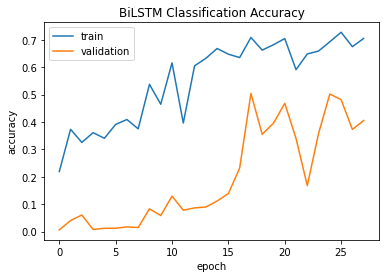

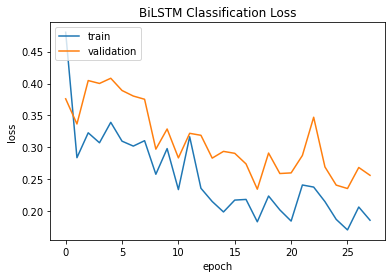

In [53]:
BiLSTM_2_history_dict = BiLSTM_2_fit.history
plt.plot(BiLSTM_2_history_dict['accuracy'])
plt.plot(BiLSTM_2_history_dict['val_accuracy'])

plt.title('BiLSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiLSTM_2_history_dict['loss'])
plt.plot(BiLSTM_2_history_dict['val_loss'])

plt.title('BiLSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [54]:
BiLSTM_pred = BiLSTM_2_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiLSTM_2_predictions = (BiLSTM_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTM_2_predictions))

444/444 [==============================] - 167s 375ms/step
0.498432160095832


In [55]:
BiLSTM_2_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTM_2_predictions, target_names=labels, output_dict=True)
).transpose()

BiLSTM_2_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.808702,0.843457,0.825714,4165.0
kehamilan,0.832129,0.557200,0.667462,3514.0
obat,0.855801,0.454119,0.593373,3411.0
asam-lambung,0.859096,0.262027,0.401573,3118.0
bayi,0.906692,0.915530,0.911090,3078.0
sakit-kepala,0.817050,0.844276,0.830440,3031.0
benjolan,0.884973,0.882041,0.883505,3018.0
kulit,0.712756,0.240948,0.360148,3038.0
alergi,0.000000,0.000000,0.000000,3040.0
kontrasepsi,0.797668,0.382063,0.516659,3044.0


In [56]:
BiLSTM_2_cf_matrix = multilabel_confusion_matrix(y_test, BiLSTM_2_predictions)
# TN  FP
# FN  TP
BiLSTM_2_cf_matrix

array([[[23387,   831],
        [  652,  3513]],

       [[24474,   395],
        [ 1556,  1958]],

       [[24711,   261],
        [ 1862,  1549]],

       [[25131,   134],
        [ 2301,   817]],

       [[25015,   290],
        [  260,  2818]],

       [[24779,   573],
        [  472,  2559]],

       [[25019,   346],
        [  356,  2662]],

       [[25050,   295],
        [ 2306,   732]],

       [[25343,     0],
        [ 3040,     0]],

       [[25044,   295],
        [ 1881,  1163]]], dtype=int64)

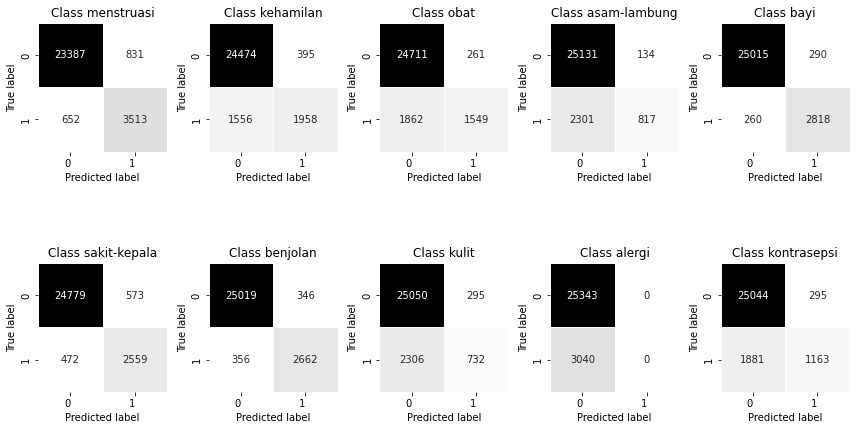

<Figure size 432x288 with 0 Axes>

In [57]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiLSTM_2_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTM_Improv1.png', bbox_inches="tight")

## Improvement 2 (single, units=16)

### Build Model

In [58]:
tf.keras.backend.clear_session()

BiLSTM_3 = Sequential()
BiLSTM_3.add(Input(shape=(max_length,)))
BiLSTM_3.add(Embedding(input_dim, output_dim, weights=[embedding_matrix], trainable=False))
BiLSTM_3.add(Bidirectional(LSTM(16, return_sequences=True)))
BiLSTM_3.add(Dropout(0.2))
BiLSTM_3.add(GlobalMaxPool1D())
BiLSTM_3.add(Dense(10, activation='sigmoid'))

BiLSTM_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTM_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          10939500  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 32)          40576     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 32)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 10,980,406
Trainable params: 40,906
Non-tr

In [59]:
mc = ModelCheckpoint('BestModels/bilstm_3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTM_3_fit = BiLSTM_3.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
BiLSTM_3.save('BiLSTM_3')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.6104
Epoch 1: val_accuracy improved from -inf to 0.29713, saving model to BestModels\bilstm_3.h5
931/931 [==============================] - 613s 656ms/step - loss: 0.2383 - accuracy: 0.6104 - val_loss: 0.2316 - val_accuracy: 0.2971
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.7686
Epoch 2: val_accuracy improved from 0.29713 to 0.66254, saving model to BestModels\bilstm_3.h5
931/931 [==============================] - 618s 663ms/step - loss: 0.1385 - accuracy: 0.7686 - val_loss: 0.1803 - val_accuracy: 0.6625
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.7853
Epoch 3: val_accuracy improved from 0.66254 to 0.70363, saving model to BestModels\bilstm_3.h5
931/931 [==============================] - 618s 664ms/step - loss: 0.1180 - accuracy: 0.7853 - val_loss: 0.1588 - val_accuracy: 0.7036
Epoch 4/50
931/931 [=====

INFO:tensorflow:Assets written to: BiLSTM_3\assets


INFO:tensorflow:Assets written to: BiLSTM_3\assets


### Evaluate

In [60]:
BiLSTM_3_best = load_model("BestModels/bilstm_3.h5")
BiLSTM_3_train_score = BiLSTM_3_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTM_3_train_score[0])
print('Train Accuracy:', BiLSTM_3_train_score[1])

BiLSTM_3_test_score = BiLSTM_3_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTM_3_test_score[0])
print('Test Accuracy:', BiLSTM_3_test_score[1])

1035/1035 [==============================] - 344s 332ms/step - loss: 0.0749 - accuracy: 0.8326
Train Loss: 0.0749015286564827
Train Accuracy: 0.8325830101966858
444/444 [==============================] - 141s 318ms/step - loss: 0.0897 - accuracy: 0.8071
Test Loss: 0.08970290422439575
Test Accuracy: 0.8071028590202332


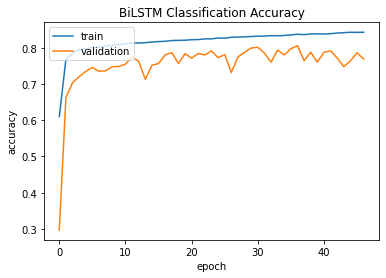

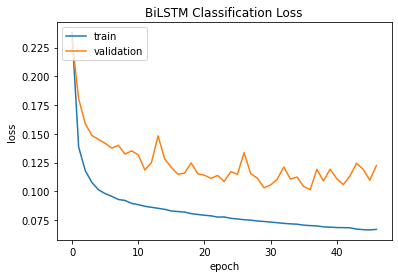

In [66]:
BiLSTM_3_history_dict = BiLSTM_3_fit.history
plt.plot(BiLSTM_3_history_dict['accuracy'])
plt.plot(BiLSTM_3_history_dict['val_accuracy'])

plt.title('BiLSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiLSTM_3_history_dict['loss'])
plt.plot(BiLSTM_3_history_dict['val_loss'])

plt.title('BiLSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [61]:
BiLSTM_pred = BiLSTM_3_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiLSTM_3_predictions = (BiLSTM_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTM_3_predictions))

444/444 [==============================] - 136s 306ms/step
0.7518585068526935


In [62]:
BiLSTM_3_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTM_3_predictions, target_names=labels, output_dict=True)
).transpose()

BiLSTM_3_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.906663,0.872269,0.889134,4165.0
kehamilan,0.847039,0.838361,0.842677,3514.0
obat,0.821996,0.758135,0.788775,3411.0
asam-lambung,0.902372,0.841886,0.871080,3118.0
bayi,0.943940,0.946394,0.945165,3078.0
sakit-kepala,0.918777,0.921808,0.920290,3031.0
benjolan,0.920779,0.939695,0.930141,3018.0
kulit,0.774702,0.663265,0.714666,3038.0
alergi,0.783691,0.600658,0.680074,3040.0
kontrasepsi,0.898305,0.853154,0.875147,3044.0


In [63]:
BiLSTM_3_cf_matrix = multilabel_confusion_matrix(y_test, BiLSTM_3_predictions)
# TN  FP
# FN  TP
BiLSTM_3_cf_matrix

array([[[23844,   374],
        [  532,  3633]],

       [[24337,   532],
        [  568,  2946]],

       [[24412,   560],
        [  825,  2586]],

       [[24981,   284],
        [  493,  2625]],

       [[25132,   173],
        [  165,  2913]],

       [[25105,   247],
        [  237,  2794]],

       [[25121,   244],
        [  182,  2836]],

       [[24759,   586],
        [ 1023,  2015]],

       [[24839,   504],
        [ 1214,  1826]],

       [[25045,   294],
        [  447,  2597]]], dtype=int64)

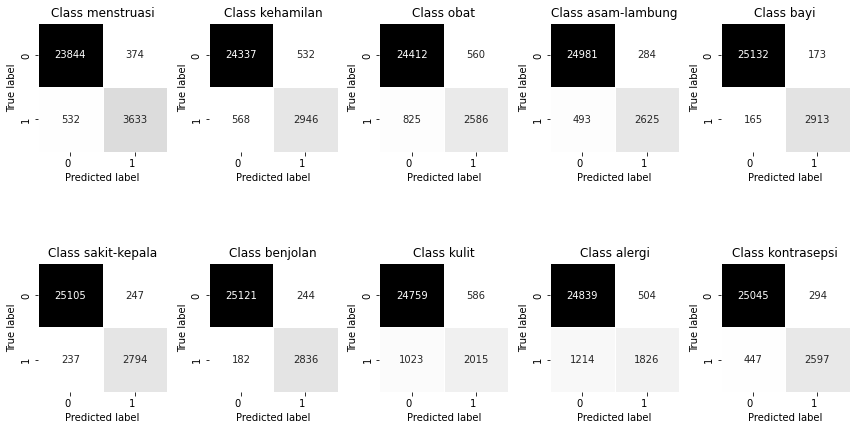

<Figure size 432x288 with 0 Axes>

In [65]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiLSTM_3_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTM_3.png', bbox_inches="tight")

## Improvement 3 (single, units=8)

### Build Model

In [71]:
tf.keras.backend.clear_session()

In [72]:
BiLSTM_4 = Sequential()
BiLSTM_4.add(Input(shape=(max_length,)))
BiLSTM_4.add(Embedding(input_dim, output_dim, weights=[embedding_matrix], trainable=False))
BiLSTM_4.add(Bidirectional(LSTM(8, return_sequences=True)))
BiLSTM_4.add(Dropout(0.2))
BiLSTM_4.add(GlobalMaxPool1D())
BiLSTM_4.add(Dense(10, activation='sigmoid'))

BiLSTM_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTM_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          10939500  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 16)          19776     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 16)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 10,959,446
Trainable params: 19,946
Non-tr

In [73]:
mc = ModelCheckpoint('BestModels/bilstm_4.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTM_4_fit = BiLSTM_4.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
BiLSTM_4.save('BiLSTM_4')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.3323
Epoch 1: val_accuracy improved from -inf to 0.09079, saving model to BestModels\bilstm_4.h5
931/931 [==============================] - 316s 337ms/step - loss: 0.3432 - accuracy: 0.3323 - val_loss: 0.3428 - val_accuracy: 0.0908
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.6671
Epoch 2: val_accuracy improved from 0.09079 to 0.35091, saving model to BestModels\bilstm_4.h5
931/931 [==============================] - 312s 335ms/step - loss: 0.2097 - accuracy: 0.6671 - val_loss: 0.2559 - val_accuracy: 0.3509
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.7415
Epoch 3: val_accuracy improved from 0.35091 to 0.52356, saving model to BestModels\bilstm_4.h5
931/931 [==============================] - 304s 326ms/step - loss: 0.1599 - accuracy: 0.7415 - val_loss: 0.2212 - val_accuracy: 0.5236
Epoch 4/50
931/931 [=====

INFO:tensorflow:Assets written to: BiLSTM_4\assets


INFO:tensorflow:Assets written to: BiLSTM_4\assets


### Evaluate Model

In [74]:
BiLSTM_4_best = load_model("BestModels/bilstm_4.h5")
BiLSTM_4_train_score = BiLSTM_4_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTM_4_train_score[0])
print('Train Accuracy:', BiLSTM_4_train_score[1])

BiLSTM_4_test_score = BiLSTM_4_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTM_4_test_score[0])
print('Test Accuracy:', BiLSTM_4_test_score[1])

1035/1035 [==============================] - 193s 186ms/step - loss: 0.0859 - accuracy: 0.8252
Train Loss: 0.08587819337844849
Train Accuracy: 0.8252107501029968
444/444 [==============================] - 84s 188ms/step - loss: 0.0952 - accuracy: 0.8069
Test Loss: 0.09517515450716019
Test Accuracy: 0.8068562150001526


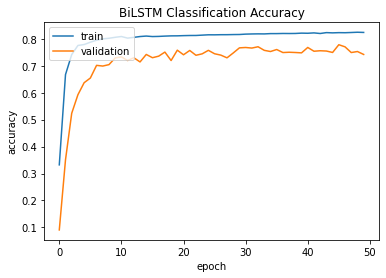

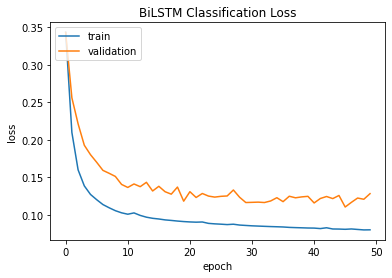

In [75]:
BiLSTM_4_history_dict = BiLSTM_4_fit.history
plt.plot(BiLSTM_4_history_dict['accuracy'])
plt.plot(BiLSTM_4_history_dict['val_accuracy'])

plt.title('BiLSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiLSTM_4_history_dict['loss'])
plt.plot(BiLSTM_4_history_dict['val_loss'])

plt.title('BiLSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [76]:
BiLSTM_pred = BiLSTM_4_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiLSTM_4_predictions = (BiLSTM_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTM_4_predictions))

444/444 [==============================] - 70s 158ms/step
0.7314237395624141


In [77]:
BiLSTM_4_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTM_4_predictions, target_names=labels, output_dict=True)
).transpose()

BiLSTM_4_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.891866,0.879232,0.885504,4165.0
kehamilan,0.855483,0.817018,0.835808,3514.0
obat,0.825137,0.752565,0.787182,3411.0
asam-lambung,0.904076,0.825208,0.862844,3118.0
bayi,0.940294,0.936322,0.938304,3078.0
sakit-kepala,0.918185,0.914550,0.916364,3031.0
benjolan,0.935056,0.911199,0.922974,3018.0
kulit,0.696115,0.731402,0.713323,3038.0
alergi,0.782188,0.531579,0.632981,3040.0
kontrasepsi,0.908723,0.811104,0.857143,3044.0


In [78]:
BiLSTM_4_cf_matrix = multilabel_confusion_matrix(y_test, BiLSTM_4_predictions)
# TN  FP
# FN  TP
BiLSTM_4_cf_matrix

array([[[23774,   444],
        [  503,  3662]],

       [[24384,   485],
        [  643,  2871]],

       [[24428,   544],
        [  844,  2567]],

       [[24992,   273],
        [  545,  2573]],

       [[25122,   183],
        [  196,  2882]],

       [[25105,   247],
        [  259,  2772]],

       [[25174,   191],
        [  268,  2750]],

       [[24375,   970],
        [  816,  2222]],

       [[24893,   450],
        [ 1424,  1616]],

       [[25091,   248],
        [  575,  2469]]], dtype=int64)

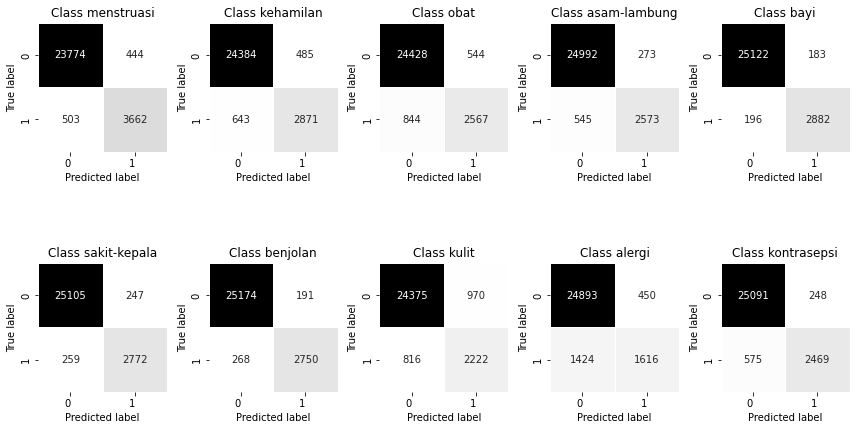

<Figure size 432x288 with 0 Axes>

In [79]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiLSTM_4_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTM_Improv3.png', bbox_inches="tight")

## Improvement 4 (stacked, units=8-16-32)

### Build Model

In [80]:
tf.keras.backend.clear_session()

BiLSTM_5 = Sequential()
BiLSTM_5.add(Input(shape=(max_length,)))
BiLSTM_5.add(Embedding(input_dim, output_dim, weights=[embedding_matrix], trainable=False))
BiLSTM_5.add(Bidirectional(LSTM(8, return_sequences=True)))
BiLSTM_5.add(Dropout(0.2))
BiLSTM_5.add(Bidirectional(LSTM(16, return_sequences=True)))
BiLSTM_5.add(Dropout(0.2))
BiLSTM_5.add(Bidirectional(LSTM(32, return_sequences=True)))
BiLSTM_5.add(Dropout(0.2))
BiLSTM_5.add(GlobalMaxPool1D())
BiLSTM_5.add(Dense(10, activation='sigmoid'))

BiLSTM_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTM_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          10939500  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 16)          19776     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 16)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 32)          4224      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 300, 32)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 64)          1

In [81]:
plot_model(BiLSTM_5, to_file='bilstm_5.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [83]:
mc = ModelCheckpoint('BestModels/bilstm_5.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTM_5_fit = BiLSTM_5.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
BiLSTM_5_history_dict = BiLSTM_5_fit.history
BiLSTM_5.save('BiLSTM_5')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.3977
Epoch 1: val_accuracy improved from -inf to 0.34864, saving model to BestModels\bilstm_5.h5
931/931 [==============================] - 542s 577ms/step - loss: 0.2781 - accuracy: 0.3977 - val_loss: 0.2526 - val_accuracy: 0.3486
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.7440
Epoch 2: val_accuracy improved from 0.34864 to 0.57538, saving model to BestModels\bilstm_5.h5
931/931 [==============================] - 555s 596ms/step - loss: 0.1431 - accuracy: 0.7440 - val_loss: 0.1888 - val_accuracy: 0.5754
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.7787
Epoch 3: val_accuracy improved from 0.57538 to 0.72840, saving model to BestModels\bilstm_5.h5
931/931 [==============================] - 561s 603ms/step - loss: 0.1148 - accuracy: 0.7787 - val_loss: 0.1514 - val_accuracy: 0.7284
Epoch 4/50
931/931 [=====

INFO:tensorflow:Assets written to: BiLSTM_5\assets


INFO:tensorflow:Assets written to: BiLSTM_5\assets


### Evaluate Model

In [85]:
BiLSTM_5_best = load_model("BestModels/bilstm_5.h5")
BiLSTM_5_train_score = BiLSTM_5_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTM_5_train_score[0])
print('Train Accuracy:', BiLSTM_5_train_score[1])

BiLSTM_5_test_score = BiLSTM_5_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTM_5_test_score[0])
print('Test Accuracy:', BiLSTM_5_test_score[1])

1035/1035 [==============================] - 170s 163ms/step - loss: 0.0808 - accuracy: 0.8201
Train Loss: 0.08078473806381226
Train Accuracy: 0.8201347589492798
444/444 [==============================] - 71s 160ms/step - loss: 0.0914 - accuracy: 0.8045
Test Loss: 0.09135893732309341
Test Accuracy: 0.804495632648468


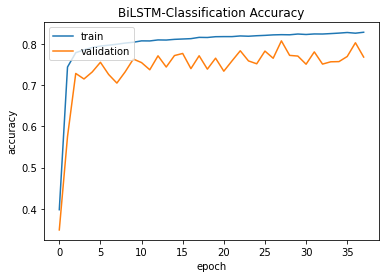

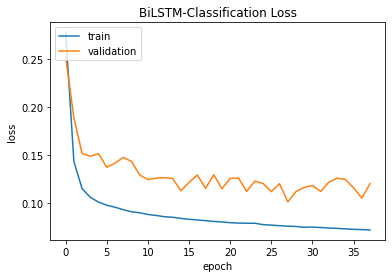

In [86]:
plt.plot(BiLSTM_5_history_dict['accuracy'])
plt.plot(BiLSTM_5_history_dict['val_accuracy'])

plt.title('BiLSTM-Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiLSTM_5_history_dict['loss'])
plt.plot(BiLSTM_5_history_dict['val_loss'])

plt.title('BiLSTM-Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [88]:
BiLSTM_5_pred = BiLSTM_5_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiLSTM_5_predictions = (BiLSTM_5_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTM_5_predictions))

444/444 [==============================] - 64s 144ms/step
0.7432970440052143


In [89]:
BiLSTM_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTM_5_predictions, target_names=labels, output_dict=True)
).transpose()

BiLSTM_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.885681,0.905882,0.895668,4165.0
kehamilan,0.811321,0.881047,0.844748,3514.0
obat,0.810472,0.776019,0.792871,3411.0
asam-lambung,0.859962,0.880372,0.870048,3118.0
bayi,0.929529,0.968486,0.948608,3078.0
sakit-kepala,0.862478,0.960079,0.908665,3031.0
benjolan,0.926741,0.934725,0.930716,3018.0
kulit,0.711043,0.763002,0.736107,3038.0
alergi,0.726557,0.698355,0.712177,3040.0
kontrasepsi,0.876762,0.878778,0.877769,3044.0


In [90]:
BiLSTM_cf_matrix = multilabel_confusion_matrix(y_test, BiLSTM_5_predictions)
# TN  FP
# FN  TP
BiLSTM_cf_matrix

array([[[23731,   487],
        [  392,  3773]],

       [[24149,   720],
        [  418,  3096]],

       [[24353,   619],
        [  764,  2647]],

       [[24818,   447],
        [  373,  2745]],

       [[25079,   226],
        [   97,  2981]],

       [[24888,   464],
        [  121,  2910]],

       [[25142,   223],
        [  197,  2821]],

       [[24403,   942],
        [  720,  2318]],

       [[24544,   799],
        [  917,  2123]],

       [[24963,   376],
        [  369,  2675]]], dtype=int64)

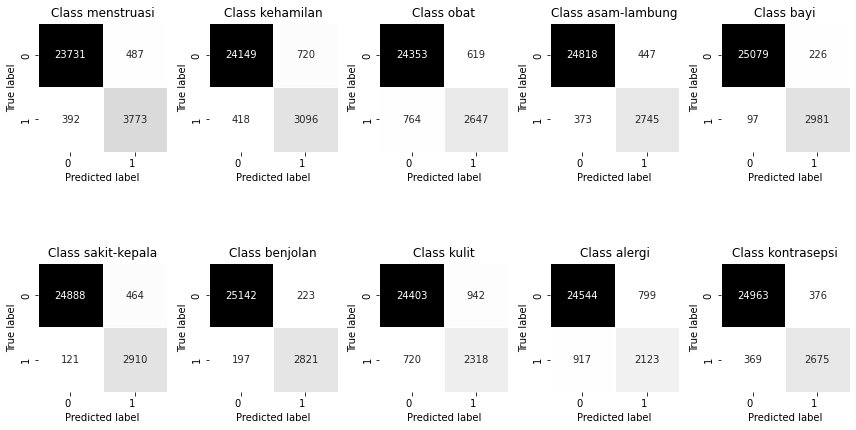

<Figure size 432x288 with 0 Axes>

In [91]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiLSTM_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTM_Improv4.png', bbox_inches="tight")

# CNN

## Multi Stack (units=50, kernel=2-3-4)

In [58]:
CNN_model = Sequential([
    Embedding(input_dim, output_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Conv1D(50, 2, padding='valid', activation='relu'),
    Dropout(0.2),
    Conv1D(50, 3, padding='valid', activation='relu'),
    Dropout(0.2),
    Conv1D(50, 4, padding='valid', activation='relu'),
    Dropout(0.2),
    GlobalMaxPool1D(),
    Dense(256, activation='relu'),
    Dense(10, activation='sigmoid')
])
CNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          10939500  
                                                                 
 conv1d_6 (Conv1D)           (None, 299, 50)           30050     
                                                                 
 dropout_5 (Dropout)         (None, 299, 50)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 297, 50)           7550      
                                                                 
 dropout_6 (Dropout)         (None, 297, 50)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 294, 50)           10050     
                                                                 
 dropout_7 (Dropout)         (None, 294, 50)          

In [59]:
mc = ModelCheckpoint('BestModels/cnn_1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
CNN_model_fit = CNN_model.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
CNN_model.save('CNN')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.6444
Epoch 1: val_accuracy improved from -inf to 0.64350, saving model to BestModels\cnn_1.h5
931/931 [==============================] - 176s 188ms/step - loss: 0.1750 - accuracy: 0.6444 - val_loss: 0.1658 - val_accuracy: 0.6435
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.7573
Epoch 2: val_accuracy improved from 0.64350 to 0.67900, saving model to BestModels\cnn_1.h5
931/931 [==============================] - 167s 179ms/step - loss: 0.1138 - accuracy: 0.7573 - val_loss: 0.1508 - val_accuracy: 0.6790
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.7711
Epoch 3: val_accuracy improved from 0.67900 to 0.73006, saving model to BestModels\cnn_1.h5
931/931 [==============================] - 166s 178ms/step - loss: 0.1046 - accuracy: 0.7711 - val_loss: 0.1254 - val_accuracy: 0.7301
Epoch 4/50
931/931 [==============

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


In [61]:
CNN_best = load_model("BestModels/cnn_1.h5")
CNN_train_score = CNN_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_train_score[0])
print('Train Accuracy:', CNN_train_score[1])

CNN_test_score = CNN_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_test_score[0])
print('Test Accuracy:', CNN_test_score[1])

1035/1035 [==============================] - 39s 37ms/step - loss: 0.0719 - accuracy: 0.8291
Train Loss: 0.07187800109386444
Train Accuracy: 0.8290907144546509
444/444 [==============================] - 17s 38ms/step - loss: 0.0891 - accuracy: 0.7974
Test Loss: 0.08912359923124313
Test Accuracy: 0.7973858714103699


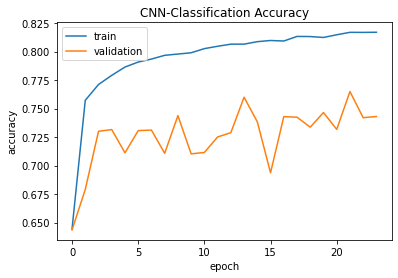

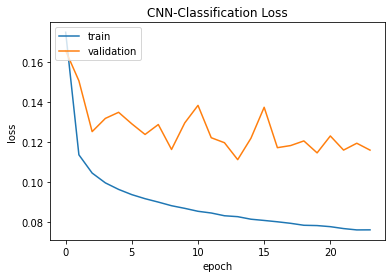

In [62]:
CNN_history_dict = CNN_model_fit.history
plt.plot(CNN_history_dict['accuracy'])
plt.plot(CNN_history_dict['val_accuracy'])

plt.title('CNN-Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(CNN_history_dict['loss'])
plt.plot(CNN_history_dict['val_loss'])

plt.title('CNN-Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [63]:
CNN_pred = CNN_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
CNN_predictions = (CNN_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), CNN_predictions))

444/444 [==============================] - 16s 37ms/step
0.7439402480270575


In [64]:
CNN_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), CNN_predictions, target_names=labels, output_dict=True)
).transpose()

CNN_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.852722,0.906363,0.878724,4165.0
kehamilan,0.847194,0.837792,0.842467,3514.0
obat,0.786981,0.793902,0.790426,3411.0
asam-lambung,0.923827,0.789609,0.851461,3118.0
bayi,0.929371,0.970435,0.949460,3078.0
sakit-kepala,0.879358,0.940284,0.908801,3031.0
benjolan,0.902699,0.952949,0.927144,3018.0
kulit,0.701267,0.764977,0.731738,3038.0
alergi,0.758039,0.620395,0.682344,3040.0
kontrasepsi,0.879043,0.892904,0.885919,3044.0


In [65]:
CNN_cf_matrix = multilabel_confusion_matrix(y_test, CNN_predictions)
# TN  FP
# FN  TP
CNN_cf_matrix

array([[[23567,   652],
        [  390,  3775]],

       [[24339,   531],
        [  570,  2944]],

       [[24240,   733],
        [  703,  2708]],

       [[25063,   203],
        [  656,  2462]],

       [[25079,   227],
        [   91,  2987]],

       [[24962,   391],
        [  181,  2850]],

       [[25056,   310],
        [  142,  2876]],

       [[24356,   990],
        [  714,  2324]],

       [[24742,   602],
        [ 1154,  1886]],

       [[24966,   374],
        [  326,  2718]]], dtype=int64)

# BiLSTM - CNN

In [81]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
bilstm2 = Bidirectional(LSTM(64))(embedding2)
drop2 = Dropout(0.5)(bilstm2)
out2 = Dense(10, activation='sigmoid')(drop2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
BiLSTMCNN = Model(inputs=[input1, input2], outputs=outputs)

BiLSTMCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     12327600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                              

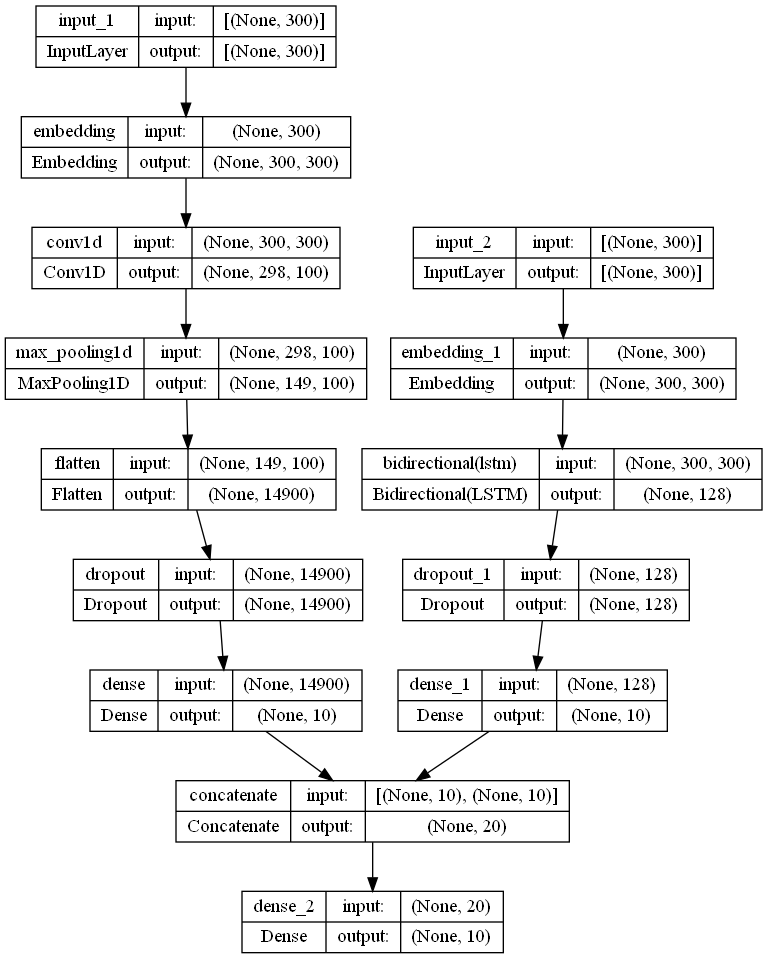

In [93]:
plot_model(BiLSTMCNN, to_file="PlotModels/bilstmcnn.png", show_shapes=True)

In [82]:
mc = ModelCheckpoint('BestModels/bilstmcnn_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTMCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

BiLSTMCNN_fit = BiLSTMCNN.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
BiLSTMCNN.save('BiLSTMCNN_fixtypo')

Epoch 1/50
1007/1007 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.3947
Epoch 1: val_accuracy improved from -inf to 0.70126, saving model to BestModels\bilstmcnn_fixtypo.h5
1007/1007 [==============================] - 475s 470ms/step - loss: 0.2835 - accuracy: 0.3947 - val_loss: 0.1967 - val_accuracy: 0.7013
Epoch 2/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.7698
Epoch 2: val_accuracy improved from 0.70126 to 0.82947, saving model to BestModels\bilstmcnn_fixtypo.h5
1007/1007 [==============================] - 472s 468ms/step - loss: 0.1543 - accuracy: 0.7698 - val_loss: 0.1167 - val_accuracy: 0.8295
Epoch 3/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.8289
Epoch 3: val_accuracy improved from 0.82947 to 0.83757, saving model to BestModels\bilstmcnn_fixtypo.h5
1007/1007 [==============================] - 471s 468ms/step - loss: 0.1084 - accuracy: 0.8289 - val_loss: 0.0967 - val_acc

INFO:tensorflow:Assets written to: BiLSTMCNN_fixtypo\assets


INFO:tensorflow:Assets written to: BiLSTMCNN_fixtypo\assets


## Evaluate

In [83]:
BiLSTMCNN_best = load_model('BestModels/bilstmcnn_fixtypo.h5')
BiLSTMCNN_train_score = BiLSTMCNN_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTMCNN_train_score[0])
print('Train Accuracy:', BiLSTMCNN_train_score[1])

BiLSTMCNN_test_score = BiLSTMCNN_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTMCNN_test_score[0])
print('Test Accuracy:', BiLSTMCNN_test_score[1])

1119/1119 [==============================] - 758s 677ms/step - loss: 0.0457 - accuracy: 0.9103
Train Loss: 0.04565737396478653
Train Accuracy: 0.9102793335914612
480/480 [==============================] - 327s 681ms/step - loss: 0.0833 - accuracy: 0.8470
Test Loss: 0.08332299441099167
Test Accuracy: 0.8470361828804016


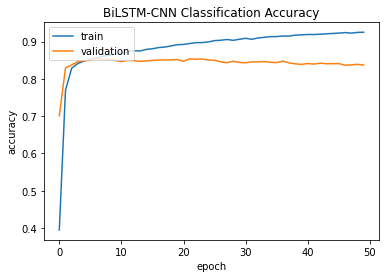

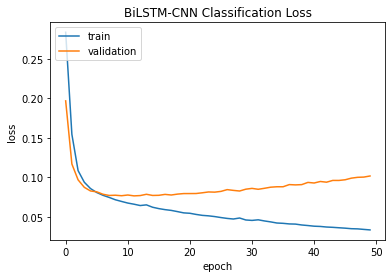

In [84]:
BiLSTMCNN_history_dict = BiLSTMCNN_fit.history
plt.plot(BiLSTMCNN_history_dict['accuracy'])
plt.plot(BiLSTMCNN_history_dict['val_accuracy'])

plt.title('BiLSTM-CNN Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiLSTMCNN_history_dict['loss'])
plt.plot(BiLSTMCNN_history_dict['val_loss'])

plt.title('BiLSTM-CNN Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [85]:
BiLSTMCNN_y_pred = BiLSTMCNN_best.predict([X_test, X_test], batch_size=batch_size2, verbose=1)
# lebih dari 0.5 dihitung sebagai 1
BiLSTMCNN_predictions = (BiLSTMCNN_y_pred > 0.5).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTMCNN_predictions))

480/480 [==============================] - 309s 642ms/step
0.7885749665982338


In [86]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), BiLSTMCNN_predictions)
hamming_loss.result().numpy()

0.029856278

In [87]:
BiLSTMCNN_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTMCNN_predictions, target_names=labels, output_dict=True)
).transpose()

BiLSTMCNN_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.882169,0.926316,0.903704,5795.0
kehamilan,0.894812,0.896804,0.895807,6289.0
obat,0.836497,0.788202,0.811632,3187.0
asam-lambung,0.901070,0.893248,0.897142,3110.0
bayi,0.941802,0.950726,0.946243,3166.0
sakit-kepala,0.936684,0.887769,0.911571,2183.0
benjolan,0.906279,0.923591,0.914853,2094.0
kulit,0.735742,0.650500,0.690501,2598.0
alergi,0.700801,0.664934,0.682396,2501.0
kontrasepsi,0.865207,0.785683,0.823529,2263.0


In [88]:
BiLSTMCNN_cf_matrix = multilabel_confusion_matrix(y_test, BiLSTMCNN_predictions)
# TN  FP
# FN  TP
BiLSTMCNN_cf_matrix

array([[[24175,   717],
        [  427,  5368]],

       [[23735,   663],
        [  649,  5640]],

       [[27009,   491],
        [  675,  2512]],

       [[27272,   305],
        [  332,  2778]],

       [[27335,   186],
        [  156,  3010]],

       [[28373,   131],
        [  245,  1938]],

       [[28393,   200],
        [  160,  1934]],

       [[27482,   607],
        [  908,  1690]],

       [[27476,   710],
        [  838,  1663]],

       [[28147,   277],
        [  485,  1778]]], dtype=int64)

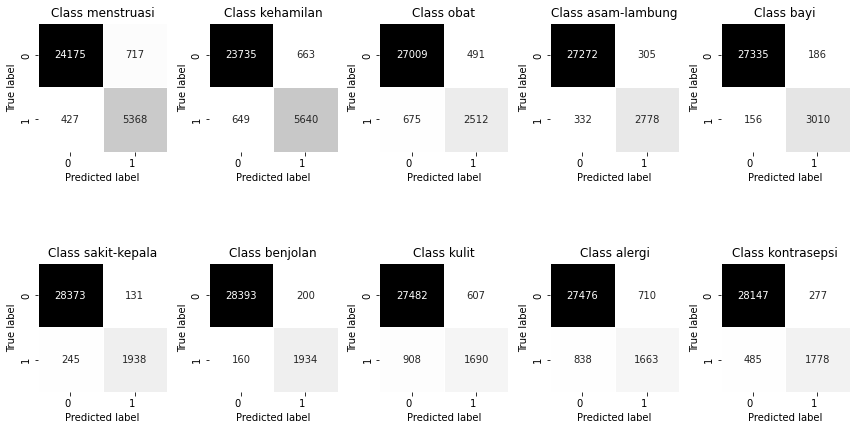

<Figure size 432x288 with 0 Axes>

In [89]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiLSTMCNN_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTMCNN_fixtypo.png', bbox_inches="tight")

## Same -- LSTM units = 32

In [24]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
bilstm2 = Bidirectional(LSTM(32))(embedding2)
drop2 = Dropout(0.5)(bilstm2)
out2 = Dense(10, activation='sigmoid')(drop2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
BiLSTMCNN2 = Model(inputs=[input1, input2], outputs=outputs)

BiLSTMCNN2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     12327600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                              

In [25]:
mc = ModelCheckpoint('BestModels/bilstmcnn2_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiLSTMCNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

BiLSTMCNN2_fit = BiLSTMCNN2.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
BiLSTMCNN2.save('BiLSTMCNN2_fixtypo')

Epoch 1/50
1007/1007 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.3740
Epoch 1: val_accuracy improved from -inf to 0.78673, saving model to BestModels\bilstmcnn2_fixtypo.h5
1007/1007 [==============================] - 289s 286ms/step - loss: 0.3026 - accuracy: 0.3740 - val_loss: 0.1845 - val_accuracy: 0.7867
Epoch 2/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.8057
Epoch 2: val_accuracy improved from 0.78673 to 0.83310, saving model to BestModels\bilstmcnn2_fixtypo.h5
1007/1007 [==============================] - 237s 235ms/step - loss: 0.1441 - accuracy: 0.8057 - val_loss: 0.1153 - val_accuracy: 0.8331
Epoch 3/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.8361
Epoch 3: val_accuracy improved from 0.83310 to 0.84441, saving model to BestModels\bilstmcnn2_fixtypo.h5
1007/1007 [==============================] - 247s 245ms/step - loss: 0.1080 - accuracy: 0.8361 - val_loss: 0.0972 - val_

INFO:tensorflow:Assets written to: BiLSTMCNN2_fixtypo\assets


INFO:tensorflow:Assets written to: BiLSTMCNN2_fixtypo\assets


### Evaluate

In [26]:
BiLSTMCNN2_best = load_model('BestModels/bilstmcnn2_fixtypo.h5')
BiLSTMCNN2_train_score = BiLSTMCNN2_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTMCNN2_train_score[0])
print('Train Accuracy:', BiLSTMCNN2_train_score[1])

BiLSTMCNN2_test_score = BiLSTMCNN2_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTMCNN2_test_score[0])
print('Test Accuracy:', BiLSTMCNN2_test_score[1])

1119/1119 [==============================] - 133s 118ms/step - loss: 0.0545 - accuracy: 0.8966
Train Loss: 0.0545315258204937
Train Accuracy: 0.8965781927108765
480/480 [==============================] - 59s 122ms/step - loss: 0.0815 - accuracy: 0.8486
Test Loss: 0.08154139667749405
Test Accuracy: 0.84856778383255


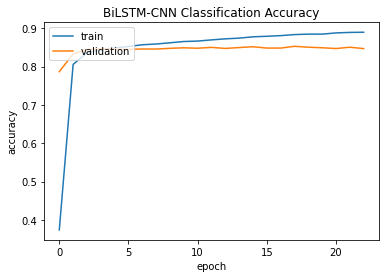

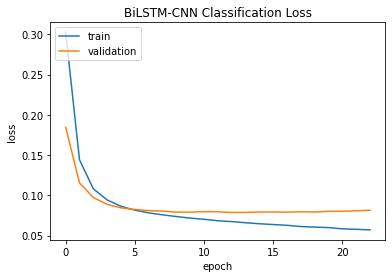

In [27]:
BiLSTMCNN2_history_dict = BiLSTMCNN2_fit.history
plt.plot(BiLSTMCNN2_history_dict['accuracy'])
plt.plot(BiLSTMCNN2_history_dict['val_accuracy'])

plt.title('BiLSTM-CNN Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiLSTMCNN2_history_dict['loss'])
plt.plot(BiLSTMCNN2_history_dict['val_loss'])

plt.title('BiLSTM-CNN Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [28]:
BiLSTMCNN2_y_pred = BiLSTMCNN2_best.predict([X_test, X_test], batch_size=batch_size2, verbose=1)
# lebih dari 0.5 dihitung sebagai 1
BiLSTMCNN2_predictions = (BiLSTMCNN2_y_pred > 0.5).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTMCNN2_predictions))

480/480 [==============================] - 56s 117ms/step
0.7848926255417603


In [29]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), BiLSTMCNN2_predictions)
hamming_loss.result().numpy()

0.03005832

In [34]:
BiLSTMCNN2_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTMCNN2_predictions, target_names=labels, output_dict=True)
).transpose()

BiLSTMCNN2_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.877950,0.930975,0.903685,5795.0
kehamilan,0.887964,0.898553,0.893227,6289.0
obat,0.847894,0.764355,0.803960,3187.0
asam-lambung,0.897706,0.905788,0.901729,3110.0
bayi,0.938119,0.957675,0.947796,3166.0
sakit-kepala,0.921053,0.913880,0.917452,2183.0
benjolan,0.927487,0.904011,0.915599,2094.0
kulit,0.693977,0.714011,0.703851,2598.0
alergi,0.735166,0.609356,0.666375,2501.0
kontrasepsi,0.853436,0.784799,0.817680,2263.0


In [36]:
BiLSTMCNN2_cf_matrix = multilabel_confusion_matrix(y_test, BiLSTMCNN2_predictions)
# TN  TP
# FN  FP
BiLSTMCNN2_cf_matrix

array([[[24142,   750],
        [  400,  5395]],

       [[23685,   713],
        [  638,  5651]],

       [[27063,   437],
        [  751,  2436]],

       [[27256,   321],
        [  293,  2817]],

       [[27321,   200],
        [  134,  3032]],

       [[28333,   171],
        [  188,  1995]],

       [[28445,   148],
        [  201,  1893]],

       [[27271,   818],
        [  743,  1855]],

       [[27637,   549],
        [  977,  1524]],

       [[28119,   305],
        [  487,  1776]]], dtype=int64)

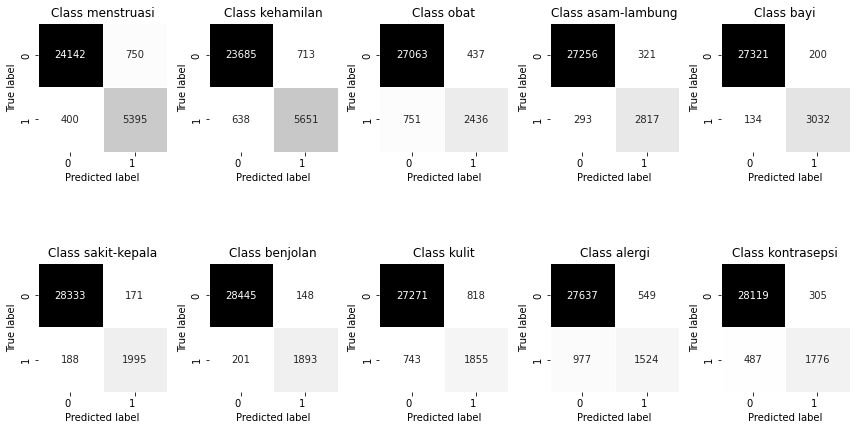

<Figure size 432x288 with 0 Axes>

In [37]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiLSTMCNN2_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTMCNN2_fixtypo.png', bbox_inches="tight")

# LSTM

## (👑 Current Best) Original (single, units = 32)

### Build Model

In [32]:
tf.keras.backend.clear_session()

LSTM_model = Sequential([
    Embedding(input_dim, output_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(units=32, return_sequences=True),
    Dropout(0.2),
    GlobalMaxPool1D(),
    Dense(10, activation='sigmoid')
])

LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          12327600  
                                                                 
 lstm (LSTM)                 (None, 300, 32)           42624     
                                                                 
 dropout (Dropout)           (None, 300, 32)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 12,370,554
Trainable params: 42,954
Non-trainable params: 12,327,600
_______________________________________

In [34]:
mc = ModelCheckpoint('BestModels/lstm_fixtypo2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
LSTM_model.save('LSTM_fixtypo2')

Epoch 1/50
1007/1007 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.5232
Epoch 1: val_accuracy improved from -inf to 0.77109, saving model to BestModels\lstm_fixtypo2.h5
1007/1007 [==============================] - 78s 76ms/step - loss: 0.2603 - accuracy: 0.5232 - val_loss: 0.1747 - val_accuracy: 0.7711
Epoch 2/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.7816
Epoch 2: val_accuracy improved from 0.77109 to 0.80908, saving model to BestModels\lstm_fixtypo2.h5
1007/1007 [==============================] - 78s 78ms/step - loss: 0.1345 - accuracy: 0.7816 - val_loss: 0.1326 - val_accuracy: 0.8091
Epoch 3/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.8125
Epoch 3: val_accuracy improved from 0.80908 to 0.82291, saving model to BestModels\lstm_fixtypo2.h5
1007/1007 [==============================] - 86s 86ms/step - loss: 0.1090 - accuracy: 0.8125 - val_loss: 0.1125 - val_accuracy: 0.8229
Epoc

INFO:tensorflow:Assets written to: LSTM_fixtypo2\assets


INFO:tensorflow:Assets written to: LSTM_fixtypo2\assets


### Evaluate Model

In [35]:
LSTM_best = load_model('BestModels/lstm_fixtypo2.h5')
LSTM_train_score = LSTM_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', LSTM_train_score[0])
print('Train Accuracy:', LSTM_train_score[1])

LSTM_test_score = LSTM_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', LSTM_test_score[0])
print('Test Accuracy:', LSTM_test_score[1])

1119/1119 [==============================] - 64s 57ms/step - loss: 0.0708 - accuracy: 0.8710
Train Loss: 0.07081103324890137
Train Accuracy: 0.8710195422172546
480/480 [==============================] - 33s 69ms/step - loss: 0.0802 - accuracy: 0.8494
Test Loss: 0.08022616058588028
Test Accuracy: 0.8494476675987244


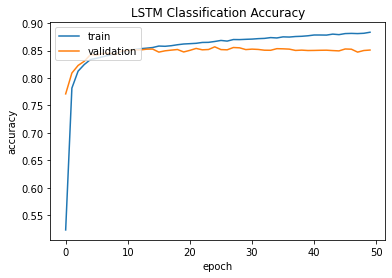

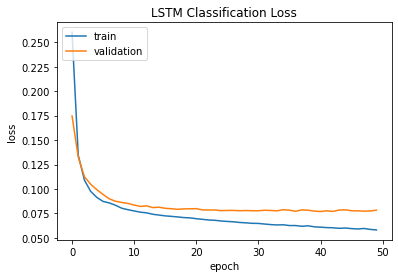

In [36]:
LSTM_history_dict = LSTM_model_fit.history
plt.plot(LSTM_history_dict['accuracy'])
plt.plot(LSTM_history_dict['val_accuracy'])

plt.title('LSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(LSTM_history_dict['loss'])
plt.plot(LSTM_history_dict['val_loss'])

plt.title('LSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [37]:
LSTM_pred = LSTM_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
LSTM_predictions = (LSTM_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), LSTM_predictions))

480/480 [==============================] - 20s 41ms/step
0.7810799361293056


In [38]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), LSTM_predictions)
hamming_loss.result().numpy()

0.029895384

In [39]:
LSTM_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), LSTM_predictions, target_names=labels, output_dict=True)
).transpose()

LSTM_report_df

NameError: name 'labels' is not defined

In [ ]:
LSTM_cf_matrix = multilabel_confusion_matrix(y_test, LSTM_predictions)
# TN  FP
# FN  TP
LSTM_cf_matrix

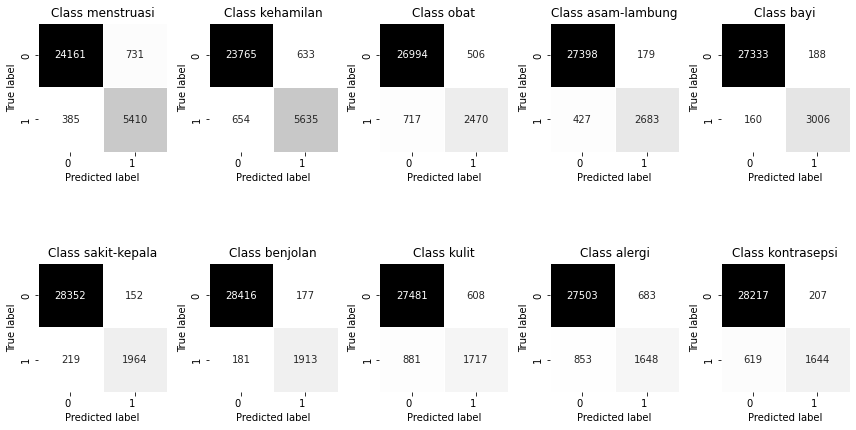

<Figure size 432x288 with 0 Axes>

In [46]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), LSTM_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/LSTM_fixtypo.png', bbox_inches="tight")

## Improvement 1 (single, units=16)

### Build Model

In [110]:
tf.keras.backend.clear_session()

inputs = Input(shape=(max_length,))
x = Embedding(input_dim, output_dim, weights=[embedding_matrix], trainable=False)(inputs)
x = LSTM(16, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(10, activation='sigmoid')(x)
LSTM_1 = Model(inputs=inputs, outputs=outputs)

LSTM_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          10939500  
                                                                 
 lstm (LSTM)                 (None, 300, 16)           20288     
                                                                 
 dropout (Dropout)           (None, 300, 16)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                170       
                                                             

In [111]:
mc = ModelCheckpoint('BestModels/lstm_1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
LSTM_1_fit = LSTM_1.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[es, mc])
LSTM_1.save('LSTM_1')

Epoch 1/50
931/931 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.4402
Epoch 1: val_accuracy improved from -inf to 0.05151, saving model to BestModels\lstm_1.h5
931/931 [==============================] - 558s 599ms/step - loss: 0.3095 - accuracy: 0.4402 - val_loss: 0.3341 - val_accuracy: 0.0515
Epoch 2/50
931/931 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.6505
Epoch 2: val_accuracy improved from 0.05151 to 0.08640, saving model to BestModels\lstm_1.h5
931/931 [==============================] - 558s 599ms/step - loss: 0.2098 - accuracy: 0.6505 - val_loss: 0.2848 - val_accuracy: 0.0864
Epoch 3/50
931/931 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.7110
Epoch 3: val_accuracy improved from 0.08640 to 0.11813, saving model to BestModels\lstm_1.h5
931/931 [==============================] - 558s 600ms/step - loss: 0.1622 - accuracy: 0.7110 - val_loss: 0.2639 - val_accuracy: 0.1181
Epoch 4/50
931/931 [===========

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


### Evaluate Model

In [112]:
LSTM_1_best = load_model("BestModels/lstm_1.h5")
LSTM_train_1_score = LSTM_1_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', LSTM_train_1_score[0])
print('Train Accuracy:', LSTM_train_1_score[1])

LSTM_test_1_score = LSTM_1_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', LSTM_test_1_score[0])
print('Test Accuracy:', LSTM_test_1_score[1])

1035/1035 [==============================] - 414s 400ms/step - loss: 0.0917 - accuracy: 0.8158
Train Loss: 0.0917203277349472
Train Accuracy: 0.8157687783241272
444/444 [==============================] - 176s 397ms/step - loss: 0.0975 - accuracy: 0.8070
Test Loss: 0.09746363013982773
Test Accuracy: 0.8070324063301086


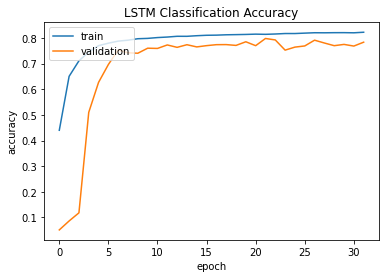

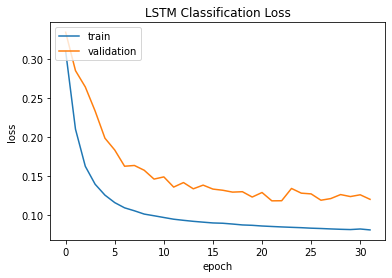

In [113]:
LSTM_1_history_dict = LSTM_1_fit.history
plt.plot(LSTM_1_history_dict['accuracy'])
plt.plot(LSTM_1_history_dict['val_accuracy'])

plt.title('LSTM Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(LSTM_1_history_dict['loss'])
plt.plot(LSTM_1_history_dict['val_loss'])

plt.title('LSTM Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [114]:
LSTM_1_pred = LSTM_1_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
LSTM_1_predictions = (LSTM_1_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), LSTM_1_predictions))

444/444 [==============================] - 175s 393ms/step
0.7352288341612937


In [115]:
LSTM_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), LSTM_1_predictions, target_names=labels, output_dict=True)
).transpose()

LSTM_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.877370,0.900120,0.888599,4165.0
kehamilan,0.856378,0.819579,0.837575,3514.0
obat,0.840665,0.711522,0.770721,3411.0
asam-lambung,0.911184,0.799551,0.851725,3118.0
bayi,0.924469,0.962313,0.943012,3078.0
sakit-kepala,0.912059,0.903332,0.907674,3031.0
benjolan,0.923888,0.929092,0.926483,3018.0
kulit,0.762838,0.640553,0.696368,3038.0
alergi,0.729751,0.616447,0.668331,3040.0
kontrasepsi,0.909923,0.816360,0.860606,3044.0


In [116]:
LSTM_cf_matrix = multilabel_confusion_matrix(y_test, LSTM_1_predictions)
# TN  FP
# FN  TP
LSTM_cf_matrix

array([[[23694,   524],
        [  416,  3749]],

       [[24386,   483],
        [  634,  2880]],

       [[24512,   460],
        [  984,  2427]],

       [[25022,   243],
        [  625,  2493]],

       [[25063,   242],
        [  116,  2962]],

       [[25088,   264],
        [  293,  2738]],

       [[25134,   231],
        [  214,  2804]],

       [[24740,   605],
        [ 1092,  1946]],

       [[24649,   694],
        [ 1166,  1874]],

       [[25093,   246],
        [  559,  2485]]], dtype=int64)

# LSTM - CNN

In [41]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
lstm2 = LSTM(64)(embedding2)
drop2 = Dropout(0.5)(lstm2)
out2 = Dense(10, activation='sigmoid')(drop2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
LSTMCNN = Model(inputs=[input1, input2], outputs=outputs)

LSTMCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTMCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     12327600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                              

In [42]:
mc = ModelCheckpoint('BestModels/lstmcnn_fixtypo2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
LSTMCNN_fit = LSTMCNN.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
LSTMCNN.save('LSTMCNN_fixtypo2')

Epoch 1/50
1007/1007 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.4282
Epoch 1: val_accuracy improved from -inf to 0.76662, saving model to BestModels\lstmcnn_fixtypo2.h5
1007/1007 [==============================] - 144s 142ms/step - loss: 0.2879 - accuracy: 0.4282 - val_loss: 0.1891 - val_accuracy: 0.7666
Epoch 2/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.7863
Epoch 2: val_accuracy improved from 0.76662 to 0.80307, saving model to BestModels\lstmcnn_fixtypo2.h5
1007/1007 [==============================] - 145s 144ms/step - loss: 0.1574 - accuracy: 0.7863 - val_loss: 0.1333 - val_accuracy: 0.8031
Epoch 3/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.8164
Epoch 3: val_accuracy improved from 0.80307 to 0.81732, saving model to BestModels\lstmcnn_fixtypo2.h5
1007/1007 [==============================] - 147s 146ms/step - loss: 0.1219 - accuracy: 0.8164 - val_loss: 0.1107 - val_accura

INFO:tensorflow:Assets written to: LSTMCNN_fixtypo2\assets


INFO:tensorflow:Assets written to: LSTMCNN_fixtypo2\assets


## Evaluate

In [50]:
LSTMCNN_best = load_model("BestModels/lstmcnn_fixtypo2.h5")
LSTMCNN_train_score = LSTMCNN_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', LSTMCNN_train_score[0])
print('Train Accuracy:', LSTMCNN_train_score[1])

LSTMCNN_test_score = LSTMCNN_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', LSTMCNN_test_score[0])
print('Test Accuracy:', LSTMCNN_test_score[1])

1119/1119 [==============================] - 95s 85ms/step - loss: 0.0450 - accuracy: 0.9189
Train Loss: 0.04500403255224228
Train Accuracy: 0.9189385771751404
480/480 [==============================] - 40s 84ms/step - loss: 0.0900 - accuracy: 0.8434
Test Loss: 0.0899929478764534
Test Accuracy: 0.8433864712715149


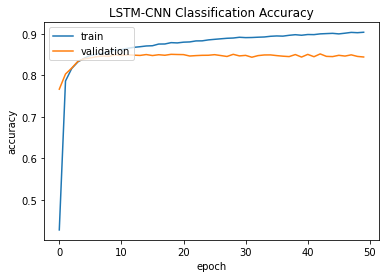

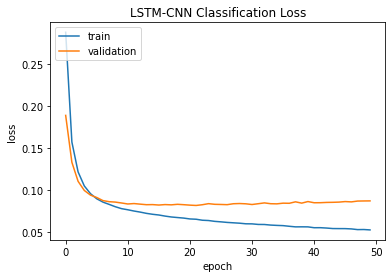

In [51]:
LSTMCNN_history_dict = LSTMCNN_fit.history
plt.plot(LSTMCNN_history_dict['accuracy'])
plt.plot(LSTMCNN_history_dict['val_accuracy'])

plt.title('LSTM-CNN Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(LSTMCNN_history_dict['loss'])
plt.plot(LSTMCNN_history_dict['val_loss'])

plt.title('LSTM-CNN Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [52]:
LSTMCNN_pred = LSTMCNN_best.predict([X_test, X_test], batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
LSTMCNN_predictions = (LSTMCNN_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), LSTMCNN_predictions))

480/480 [==============================] - 40s 83ms/step
0.7807214781503569


In [53]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), LSTMCNN_predictions)
hamming_loss.result().numpy()

0.030876255

In [54]:
LSTMCNN_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), LSTMCNN_predictions, target_names=labels, output_dict=True)
).transpose()

LSTMCNN_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.880748,0.918896,0.899417,5795.0
kehamilan,0.900629,0.887740,0.894138,6289.0
obat,0.841696,0.747411,0.791757,3187.0
asam-lambung,0.912727,0.887781,0.900081,3110.0
bayi,0.938009,0.946304,0.942138,3166.0
sakit-kepala,0.928504,0.898305,0.913155,2183.0
benjolan,0.918880,0.908787,0.913806,2094.0
kulit,0.726027,0.632410,0.675993,2598.0
alergi,0.695709,0.635346,0.664159,2501.0
kontrasepsi,0.858131,0.767123,0.810079,2263.0


In [55]:
LSTMCNN_cf_matrix = multilabel_confusion_matrix(y_test, LSTMCNN_predictions)
# TN  FP
# FN  TP
LSTMCNN_cf_matrix

array([[[24171,   721],
        [  470,  5325]],

       [[23782,   616],
        [  706,  5583]],

       [[27052,   448],
        [  805,  2382]],

       [[27313,   264],
        [  349,  2761]],

       [[27323,   198],
        [  170,  2996]],

       [[28353,   151],
        [  222,  1961]],

       [[28425,   168],
        [  191,  1903]],

       [[27469,   620],
        [  955,  1643]],

       [[27491,   695],
        [  912,  1589]],

       [[28137,   287],
        [  527,  1736]]], dtype=int64)

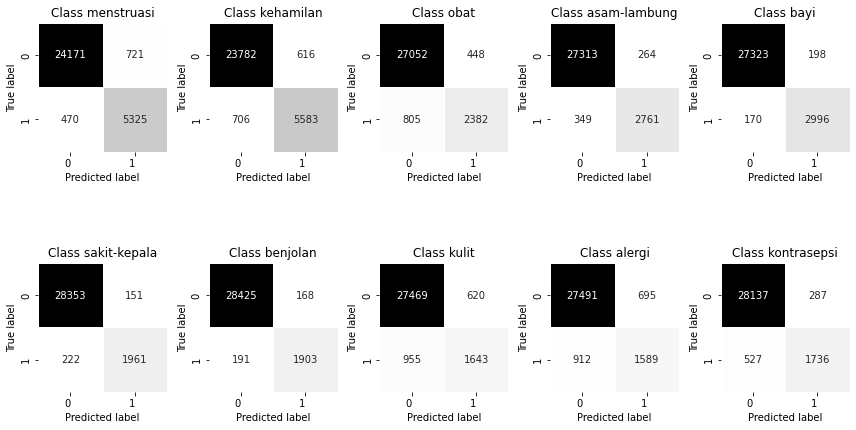

<Figure size 432x288 with 0 Axes>

In [56]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), LSTMCNN_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/LSTMCNN_fixtypo2.png', bbox_inches="tight")

# BiGRU

## Build Model

In [ ]:
inputs = Input(shape=(max_length,))
x = Embedding(input_dim, output_dim, weights=[embedding_matrix], trainable=False)(inputs)
x = Bidirectional(GRU(32, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(10, activation='sigmoid')(x)
BiGRU_1 = Model(inputs=inputs, outputs=outputs)

BiGRU_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiGRU_1.summary()

In [ ]:
mc = ModelCheckpoint('BestModels/bigru_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
BiGRU_1_fit = BiGRU_1.fit(X_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
BiGRU_1.save('BiGRU_fictypo')

## Evaluate Model

In [58]:
BiGRU_best = load_model("BestModels/bigru_fixtypo.h5")
BiGRU_train_score = BiGRU_best.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiGRU_train_score[0])
print('Train Accuracy:', BiGRU_train_score[1])

BiGRU_test_score = BiGRU_best.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiGRU_test_score[0])
print('Test Accuracy:', BiGRU_test_score[1])

1119/1119 [==============================] - 226s 201ms/step - loss: 0.0708 - accuracy: 0.8707
Train Loss: 0.07080964744091034
Train Accuracy: 0.8706983327865601
480/480 [==============================] - 97s 202ms/step - loss: 0.0804 - accuracy: 0.8504
Test Loss: 0.08043210953474045
Test Accuracy: 0.850360095500946


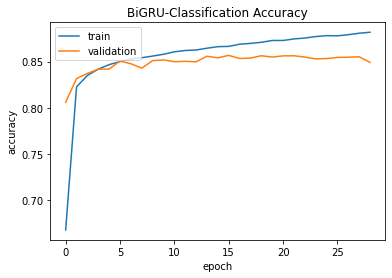

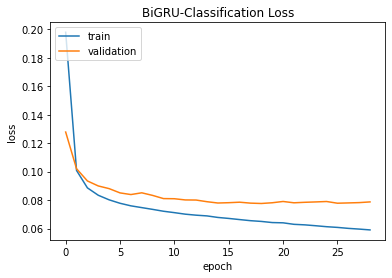

In [59]:
BiGRU_history_dict = BiGRU_1_fit.history
plt.plot(BiGRU_history_dict['accuracy'])
plt.plot(BiGRU_history_dict['val_accuracy'])

plt.title('BiGRU-Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiGRU_history_dict['loss'])
plt.plot(BiGRU_history_dict['val_loss'])

plt.title('BiGRU-Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [60]:
BiGRU_1_pred = BiGRU_best.predict(X_test, batch_size=batch_size2, verbose=1)

# lebih dari 0.5 dianggap 1
THRESHOLD_PRED = 0.5
BiGRU_1_predictions = (BiGRU_1_pred > THRESHOLD_PRED).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiGRU_1_predictions))

480/480 [==============================] - 82s 171ms/step
0.7777886401407762


In [61]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), BiGRU_1_predictions)
hamming_loss.result().numpy()

0.030015957

In [62]:
BiGRU_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiGRU_1_predictions, target_names=labels, output_dict=True)
).transpose()

BiGRU_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.868367,0.940293,0.902900,5795.0
kehamilan,0.887754,0.911751,0.899592,6289.0
obat,0.827655,0.785064,0.805797,3187.0
asam-lambung,0.894099,0.901286,0.897678,3110.0
bayi,0.939733,0.955464,0.947533,3166.0
sakit-kepala,0.922156,0.917087,0.919614,2183.0
benjolan,0.920802,0.921681,0.921241,2094.0
kulit,0.748779,0.649346,0.695527,2598.0
alergi,0.647119,0.763295,0.700422,2501.0
kontrasepsi,0.847970,0.793637,0.819904,2263.0


In [63]:
BiGRU_cf_matrix = multilabel_confusion_matrix(y_test, BiGRU_1_predictions)
# TN  FP
# FN  TP
BiGRU_cf_matrix

array([[[24066,   826],
        [  346,  5449]],

       [[23673,   725],
        [  555,  5734]],

       [[26979,   521],
        [  685,  2502]],

       [[27245,   332],
        [  307,  2803]],

       [[27327,   194],
        [  141,  3025]],

       [[28335,   169],
        [  181,  2002]],

       [[28427,   166],
        [  164,  1930]],

       [[27523,   566],
        [  911,  1687]],

       [[27145,  1041],
        [  592,  1909]],

       [[28102,   322],
        [  467,  1796]]], dtype=int64)

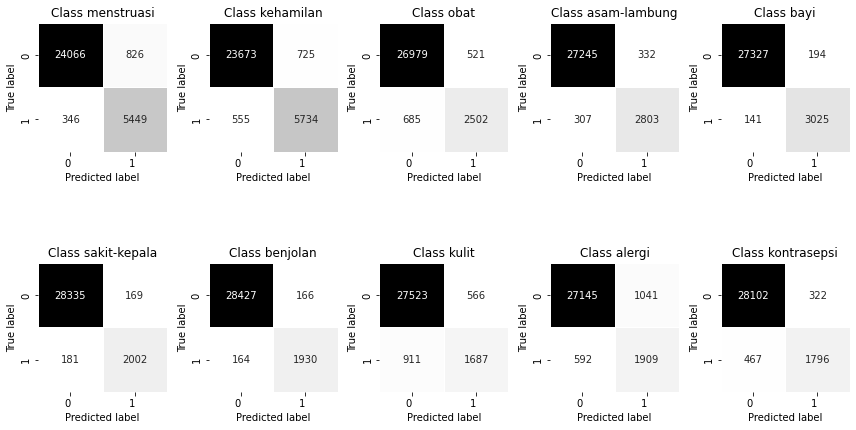

<Figure size 432x288 with 0 Axes>

In [64]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiGRU_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiGRU_fixtypo.png', bbox_inches="tight")

# BiGRU-CNN

## Build Model

In [65]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
gru2 = Bidirectional(GRU(64))(embedding2)
drop2 = Dropout(0.5)(gru2)
out2 = Dense(10, activation='sigmoid')(drop2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
BiGRUCNN = Model(inputs=[input1, input2], outputs=outputs)

BiGRUCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     12327600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                              

In [66]:
mc = ModelCheckpoint('BestModels/bigrucnn_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

BiGRUCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiGRUCNN_fit = BiGRUCNN.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
BiGRUCNN.save('BiGRUCNN_fixtypo')

Epoch 1/50
1007/1007 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.5832
Epoch 1: val_accuracy improved from -inf to 0.80573, saving model to BestModels\bigrucnn_fixtypo.h5
1007/1007 [==============================] - 214s 211ms/step - loss: 0.2457 - accuracy: 0.5832 - val_loss: 0.1462 - val_accuracy: 0.8057
Epoch 2/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.8162
Epoch 2: val_accuracy improved from 0.80573 to 0.83073, saving model to BestModels\bigrucnn_fixtypo.h5
1007/1007 [==============================] - 227s 226ms/step - loss: 0.1222 - accuracy: 0.8162 - val_loss: 0.1031 - val_accuracy: 0.8307
Epoch 3/50
1007/1007 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.8365
Epoch 3: val_accuracy improved from 0.83073 to 0.84539, saving model to BestModels\bigrucnn_fixtypo.h5
1007/1007 [==============================] - 226s 225ms/step - loss: 0.0974 - accuracy: 0.8365 - val_loss: 0.0900 - val_accura

INFO:tensorflow:Assets written to: BiGRUCNN_fixtypo\assets


INFO:tensorflow:Assets written to: BiGRUCNN_fixtypo\assets


## Evaluate Model

In [67]:
BiGRUCNN_best = load_model('BestModels/bigrucnn_fixtypo.h5')
BiGRUCNN_train_score = BiGRUCNN_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiGRUCNN_train_score[0])
print('Train Accuracy:', BiGRUCNN_train_score[1])

BiGRUCNN_test_score = BiGRUCNN_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiGRUCNN_test_score[0])
print('Test Accuracy:', BiGRUCNN_test_score[1])

1119/1119 [==============================] - 287s 256ms/step - loss: 0.0558 - accuracy: 0.8937
Train Loss: 0.055809833109378815
Train Accuracy: 0.893659234046936
480/480 [==============================] - 123s 256ms/step - loss: 0.0798 - accuracy: 0.8505
Test Loss: 0.07984977215528488
Test Accuracy: 0.8504578471183777


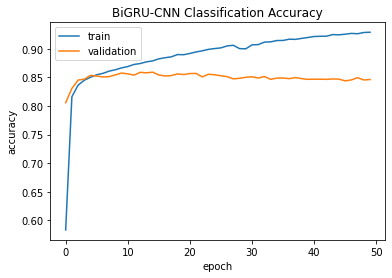

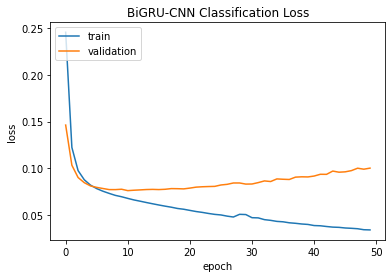

In [68]:
BiGRUCNN_history_dict = BiGRUCNN_fit.history
plt.plot(BiGRUCNN_history_dict['accuracy'])
plt.plot(BiGRUCNN_history_dict['val_accuracy'])

plt.title('BiGRU-CNN Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiGRUCNN_history_dict['loss'])
plt.plot(BiGRUCNN_history_dict['val_loss'])

plt.title('BiGRU-CNN Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [69]:
BiGRUCNN_y_pred = BiGRUCNN_best.predict([X_test, X_test], batch_size=batch_size2, verbose=1)
# lebih dari 0.5 dihitung sebagai 1
BiGRUCNN_predictions = (BiGRUCNN_y_pred > 0.5).astype(int)
BiGRUCNN_predictions

480/480 [==============================] - 123s 256ms/step


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [70]:
# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiGRUCNN_predictions))

0.7889334245771825


In [71]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), BiGRUCNN_predictions)
hamming_loss.result().numpy()

0.029224088

In [72]:
BiGRUCNN_report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiGRUCNN_predictions, target_names=labels, output_dict=True)
).transpose()

BiGRUCNN_report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.883603,0.932701,0.907488,5795.0
kehamilan,0.902875,0.898712,0.900789,6289.0
obat,0.847341,0.775024,0.809571,3187.0
asam-lambung,0.897542,0.904180,0.900849,3110.0
bayi,0.936151,0.958623,0.947253,3166.0
sakit-kepala,0.925047,0.910215,0.917571,2183.0
benjolan,0.922072,0.909742,0.915865,2094.0
kulit,0.717480,0.679369,0.697904,2598.0
alergi,0.714346,0.680928,0.697236,2501.0
kontrasepsi,0.867464,0.769333,0.815457,2263.0


In [73]:
BiGRUCNN_cf_matrix = multilabel_confusion_matrix(y_test, BiGRUCNN_predictions)
# TN  TP
# FN  FP
BiGRUCNN_cf_matrix

array([[[24180,   712],
        [  390,  5405]],

       [[23790,   608],
        [  637,  5652]],

       [[27055,   445],
        [  717,  2470]],

       [[27256,   321],
        [  298,  2812]],

       [[27314,   207],
        [  131,  3035]],

       [[28343,   161],
        [  196,  1987]],

       [[28432,   161],
        [  189,  1905]],

       [[27394,   695],
        [  833,  1765]],

       [[27505,   681],
        [  798,  1703]],

       [[28158,   266],
        [  522,  1741]]], dtype=int64)

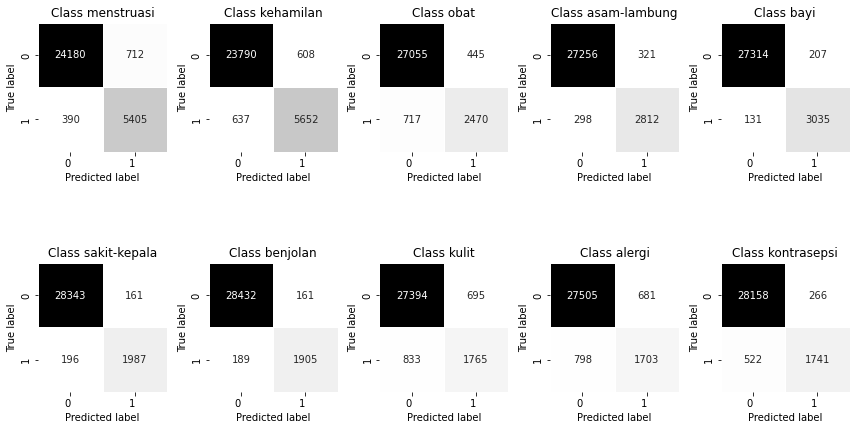

<Figure size 432x288 with 0 Axes>

In [74]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiGRUCNN_cf_matrix, labels):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiGRUCNN_fixtypo.png', bbox_inches="tight")

## Improvement (tambah globalmaxpool di rnn)

In [81]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
gru2 = Bidirectional(GRU(64, return_sequences=True))(embedding2)
drop2 = Dropout(0.5)(gru2)
pool2 = GlobalMaxPool1D()(drop2)
out2 = Dense(10, activation='sigmoid')(pool2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
BiGRUCNN2 = Model(inputs=[input1, input2], outputs=outputs)

BiGRUCNN2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     12327600    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                              

In [83]:
mc = ModelCheckpoint('BestModels/bigrucnn2_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

BiGRUCNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiGRUCNN2_fit = BiGRUCNN2.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
BiGRUCNN2.save('BiGRUCNN2_fixtypo')

Epoch 1/50
1007/1007 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.5376
Epoch 1: val_accuracy improved from -inf to 0.74693, saving model to BestModels\bigrucnn2_fixtypo.h5
1007/1007 [==============================] - 282s 278ms/step - loss: 0.2574 - accuracy: 0.5376 - val_loss: 0.1681 - val_accuracy: 0.7469
Epoch 2/50
1007/1007 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.8201
Epoch 2: val_accuracy improved from 0.74693 to 0.83743, saving model to BestModels\bigrucnn2_fixtypo.h5
1007/1007 [==============================] - 284s 282ms/step - loss: 0.1273 - accuracy: 0.8201 - val_loss: 0.1082 - val_accuracy: 0.8374
Epoch 3/50
1007/1007 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.8383
Epoch 3: val_accuracy improved from 0.83743 to 0.84022, saving model to BestModels\bigrucnn2_fixtypo.h5
1007/1007 [==============================] - 282s 280ms/step - loss: 0.0966 - accuracy: 0.8383 - val_loss: 0.0923 - val_acc

INFO:tensorflow:Assets written to: BiGRUCNN2_fixtypo\assets


INFO:tensorflow:Assets written to: BiGRUCNN2_fixtypo\assets


In [84]:
BiGRUCNN2_best = load_model('BestModels/bigrucnn2_fixtypo.h5')
BiGRUCNN2_train_score = BiGRUCNN2_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiGRUCNN2_train_score[0])
print('Train Accuracy:', BiGRUCNN2_train_score[1])

BiGRUCNN2_test_score = BiGRUCNN2_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiGRUCNN2_test_score[0])
print('Test Accuracy:', BiGRUCNN2_test_score[1])

1119/1119 [==============================] - 335s 299ms/step - loss: 0.0562 - accuracy: 0.8921
Train Loss: 0.05618821084499359
Train Accuracy: 0.8920810222625732
480/480 [==============================] - 145s 301ms/step - loss: 0.0795 - accuracy: 0.8450
Test Loss: 0.0795004665851593
Test Accuracy: 0.8450483679771423


# Utils

In [ ]:
def mapping(x):
    pred_labels = []
    for p in predictions:
        l = []
        for idx, label in enumerate(p):
            if label == 1:
                l.append(df_labels['label'].values[idx])
        pred_labels.append(l)

    actual_labels = []
    raw_labels = []
    for _, t in test_df.iterrows():
        l = []
        rl = []
        for idx, label in enumerate(t[1]):
            rl.append(label)
            if label == 1:
                l.append(df_labels['label'].values[idx])
        actual_labels.append(l)
        raw_labels.append(rl)
        
def demapping(x):
    idx = 0;
    labels = []
    for i in x:
        if i == 1:
            labels.append(df_labels['label'].values[idx])
        idx = idx+1
    return labels

In [44]:
test_df['predictions'] = predictions.tolist()
test_df['label_arr'] = test_df['labelmap'].apply(lambda x: demapping(x))
test_df['prediction_arr'] = test_df['predictions'].apply(lambda x: demapping(x))
test_df

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_2568\1047575979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predictions'] = predictions.tolist()


KeyError: 'labelmap'

In [62]:
def cosine_similarity(A, B):
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine


def get_similarity(s1, s2):
    tokenizer = load_tokenizer()
    tokenized_input = tokenize(s1, tokenizer)
    tokenized_compare = tokenize(s2, tokenizer)
    cos = cosine_similarity(tokenized_input[0], tokenized_compare[0])
    return cos

ft = load_fasttext_vocab()

In [90]:
ft = KeyedVectors.load("fasttext_gensim.model", mmap='r')
len(ft)

2000000

In [95]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

2000000

In [101]:
from scipy.spatial import distance

def get_similarity2(s1, s2, ft):
    # ft = load_fasttext_vocab()
    s1_emb = embed_for_similarity(s1, ft)
    s2_emb = embed_for_similarity(s2, ft)

    return cosine_similarity(s1_emb, s2_emb)

In [84]:
from nlp_id.lemmatizer import Lemmatizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

def load_fasttext_vocab():
    embedding_path = "cc.id.300.bin/cc.id.300.bin"
    ft = fasttext.load_facebook_model(embedding_path)
    return ft.wv


def embed_for_similarity(s, ft):
    lemmatizer = Lemmatizer()
    stop_factory = StopWordRemoverFactory()
    more_stopwords = ['halo', 'dengan', 'ia', 'bahwa', 'oleh', 'nya', 'jadi', 'untuk', 'dok', 'dokter', 'assalamualaikum', 'selamat', 'terimakasih']
    stopwords = stop_factory.get_stop_words() + more_stopwords
    
    text = s.strip().lower()
    text = re.sub(r'(\W)(?=\1)', '', text) #hapus duplikat tanda baca
    text = text.replace("\n", " ") #hapus line break
    sentence = re.sub(r'[^a-zA-Z]', ' ', text) #hapus simbol dan angka
    sentence = re.sub(r"\b[a-zA-Z]\b", " ", sentence) #remove 1 alphabet
    sentence = lemmatizer.lemmatize(sentence) # lemmatisasi
    sentence = re.sub(' +', ' ', sentence) # remove double space
    print(sentence)

    s_emb = np.mean([ft[x] for word in sentence for x in word.split() if x not in stopwords], axis=0)
    print(len(s_emb))
    return s_emb

In [102]:
from numpy.linalg import norm

text1 = "Selamat siang dok, saya ingin bertanya, amankah penggunaan pengharum ruangan (ex.stella yg digantung di kipas angin/AC) saat sedang hamil? Terimakasih"
text2 = "Apakah penggunaan pengharum ruangan aman saat sedang hamil?"
cos = get_similarity2(text1, text2, ft)
print(cos)

selamat siang dok saya ingin tanya aman guna harum ruang ex stella yg gantung di kipas angin ac saat sedang hamil terimakasih
300
apakah guna harum ruang aman saat sedang hamil
300
0.9956343


In [103]:
text1 = "Gimana caranya mengatasi mata bengkak akibat berenang selama semalam?"
text2 = "cara mengatasi muka berpori besar?"
cos = get_similarity2(text1, text2, ft)
print(cos)

gimana cara atas mata bengkak akibat renang lama malam
300
cara atas muka pori besar
300
0.9847301


In [104]:
text1 = "Apakah obat flu (Alpara) dapat dikonsumsi dengan vitamin B complex (Becom-C), Vitamin E, dan Vitamin C?"
text2 = "mengapa kepala saya sakit pas demam berdarah"
cos = get_similarity2(text1, text2, ft)
print(cos)

apakah obat flu alpara dapat konsumsi dengan vitamin complex becom vitamin dan vitamin
300
mengapa kepala saya sakit pas demam darah
300
0.9870461
